# BASIC #

In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

import dqn
from dqn import ReplayMemory, DQN

import plot_dqn as plot

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [3]:
#function for saving trained models in a folder
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [2]:
#autoreload modified modules
%load_ext autoreload
%autoreload 2

# DATA PIPELINE #

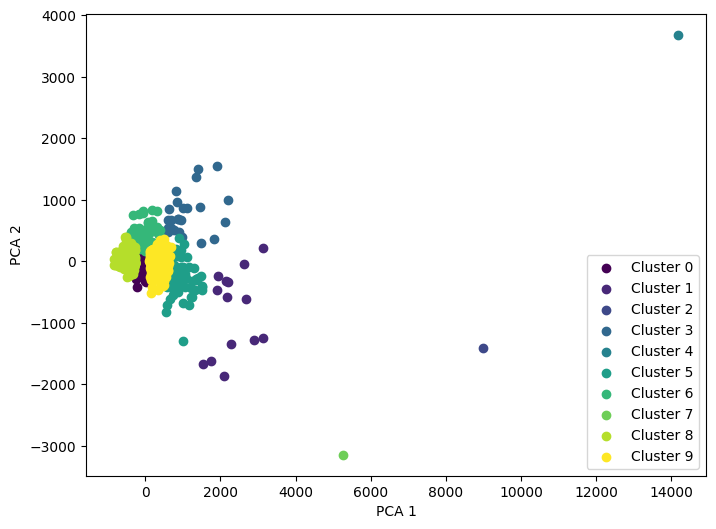

In [4]:
'''
Data pipeline:
    - Read filtered stocks closing prices as CSV/in SQL
    - Find clusters with kmeans and PCA
    - Filter out some outlier clusters; key clusters # as a dict
    - Find cointegration of each key cluster and plot heatmap
'''
import data_pipeline as pipeline
import config

pgConnStr = config.pgDictToConn(config.pgSecrets)

n_clusters = 10
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(pgConnStr), pgConnStr)
clusters = pipeline.findStockClusters(dailyDF, n_clusters)
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)
pipeline.plotStockClusters(clusters)

In [5]:
#just to check how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 306 stocks
cluster 1: 14 stocks
cluster 3: 24 stocks
cluster 5: 74 stocks
cluster 6: 70 stocks
cluster 8: 403 stocks
cluster 9: 198 stocks


[('LDP', 'CHSCN'), ('LDP', 'BLNG'), ('LDP', 'FNLC'), ('ACV', 'NIE'), ('PEBO', 'BSRR'), ('PEBO', 'MPB'), ('PEBO', 'FNLC'), ('PEBO', 'WLKP'), ('SAR', 'FCBC'), ('SAR', 'BSRR'), ('SAR', 'SMMF'), ('SAR', 'VBTX'), ('SAR', 'HSII'), ('SAR', 'AROW'), ('SAR', 'MPB'), ('SAR', 'FNLC'), ('INBK', 'PRIM'), ('BSRR', 'VBTX'), ('BSRR', 'MPB'), ('BSRR', 'FNLC'), ('ZUMZ', 'ALRS'), ('TY', 'ALRS'), ('TPB', 'BOOM'), ('SMMF', 'VBTX'), ('SMMF', 'ETO'), ('SMMF', 'CBFV'), ('SMMF', 'FNLC'), ('ALRS', 'GIC'), ('VBTX', 'MPB'), ('GNTY', 'ETO'), ('GNTY', 'FNLC'), ('GNTY', 'WLKP'), ('DCOM', 'WLKP'), ('PRIM', 'WLKP'), ('ETO', 'WLKP'), ('AROW', 'FNLC'), ('AROW', 'WLKP'), ('MPB', 'CBFV'), ('CBFV', 'FNLC'), ('FNLC', 'WLKP')]


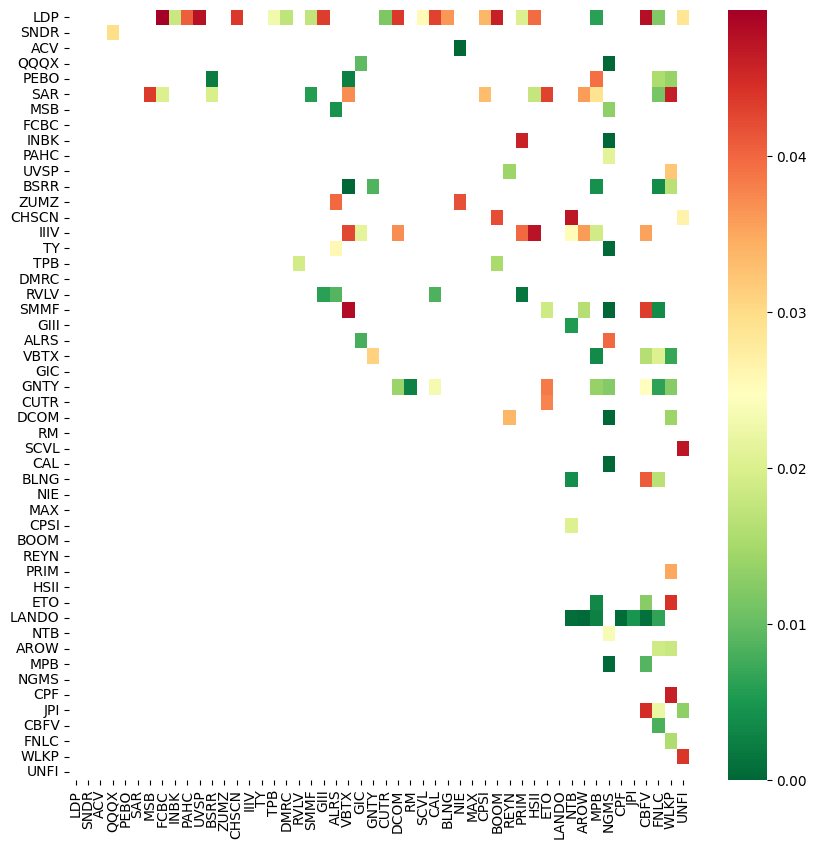

In [9]:
#split train/test data by time: 70/30#
#manually choose cluster of a reasonable size (80-100 stocks) for training model
dailyDF_train = dailyDF[good_clusters_dict[9]]

train_startdate = dailyDF_train.index[0]
train_enddate = train_startdate + pd.DateOffset(years=5)
trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF_train.loc[train_startdate:train_enddate].dropna(axis=1, how='all'))

In [10]:
#create trainenvs
window_size = 60
trade_period = 5
transaction_cost = 0.05

trainenvs = []
for trainpair in trainpairs:
    traindata = traindf[list(trainpair)].dropna()
    if traindata.shape[0] > 450:
        trainenvs.append(StockTradingEnvironment(traindata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()


[('SOHU', 'LDP'), ('SOHU', 'TCBIO'), ('SOHU', 'STK'), ('SOHU', 'CHSCN'), ('SOHU', 'WTBA'), ('SOHU', 'HTH'), ('SOHU', 'HBANP'), ('SOHU', 'KARO'), ('SOHU', 'VSTO'), ('SOHU', 'PEBO'), ('SOHU', 'CHSCL'), ('SOHU', 'JPI'), ('SOHU', 'CHSCM'), ('SOHU', 'RNA'), ('SOHU', 'RM'), ('FNLC', 'HTD'), ('OPOF', 'HESM'), ('WLKP', 'HTD'), ('HTD', 'DCOM'), ('HTD', 'UVSP'), ('LDP', 'HBANP'), ('LDP', 'JPI'), ('REYN', 'UVSP'), ('REYN', 'PEBO'), ('REYN', 'OFED'), ('TCBIO', 'KARO'), ('TCBIO', 'JPI'), ('JANX', 'CGEM'), ('STK', 'KARO'), ('STK', 'VSTO'), ('CHSCN', 'CHSCL'), ('CHSCN', 'CHSCM'), ('WTBA', 'RM'), ('CUBI', 'DWAC'), ('HTH', 'CHSCM'), ('HBANP', 'KARO'), ('KARO', 'JPI'), ('UVSP', 'NTB'), ('VSTO', 'RM'), ('PEBO', 'CHSCL'), ('PEBO', 'OFED'), ('PEBO', 'CHSCM'), ('PEBO', 'NTB'), ('CHSCL', 'CHSCM'), ('OFED', 'CHSCM'), ('OFED', 'NTB')]


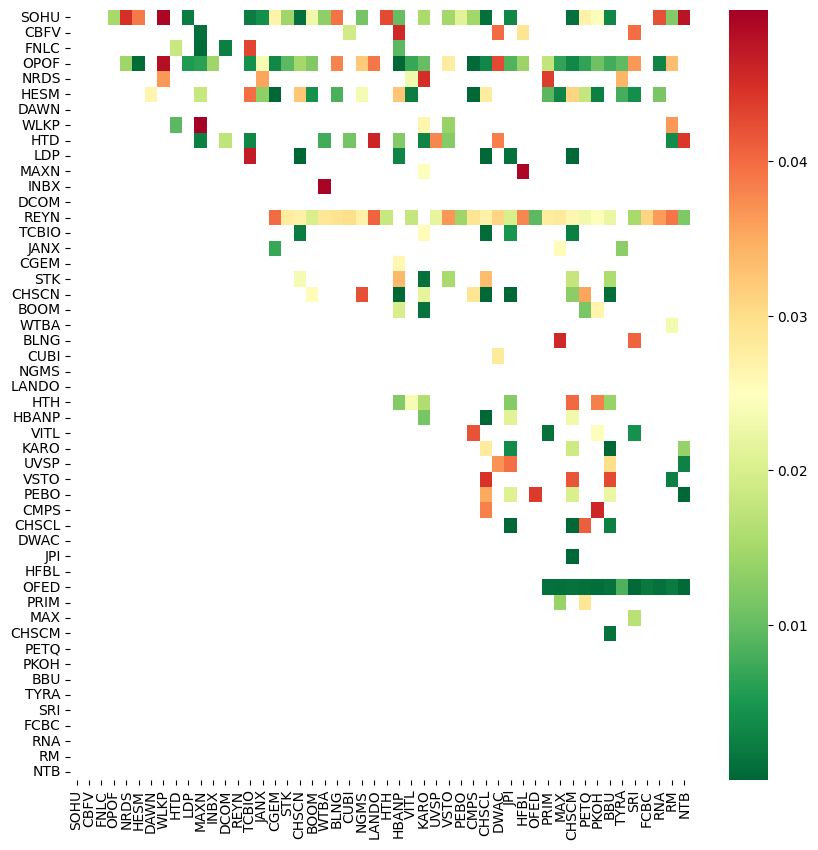

In [11]:
#val set heatmap
valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF_train.loc[train_enddate:].dropna(axis=1, how='all'))

In [12]:
#create valenvs
valenvs = []
for valpair in valpairs:
    valdata = valdf[list(valpair)].dropna()
    if valdata.shape[0] > 250:
        valenvs.append(StockTradingEnvironment(valdata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()

# DEEP Q-NETWORK #

In [25]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.02   #decreased from 0.05
EPS_DECAY = 500  #increased from 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions, device).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions, device).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-6)   #from torch.optim; RMSprop = optimizer like SGD or Adam; lr decreased from 1e-4
memory = ReplayMemory(127000)   #increased from 10000

In [26]:
#training agent
num_episodes = 5
best_rewards = 0
steps_done = 0

#empty dicts to collect train/test rewards/returns
train_reward_dict = {}
train_return_dict = {}
val_reward_dict = {}
val_return_dict = {}


for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []

    #initialize train_reward_dict and train_return_dict for this
    train_reward_dict[i_episode] = []
    train_return_dict[i_episode] = []
    val_reward_dict[i_episode] = []
    val_return_dict[i_episode] = []

    #initialize nn_counter for this episode
    nn_counter = 0
    
    for trainenv in trainenvs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = trainenv.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        
        for t in count():   #keep looping until done -> break
            # Select and perform an action and return whether this action is returned by policy_network
            action, nn_count = policy_net.select_action(state, EPS_START, EPS_END, EPS_DECAY, steps_done, policy_net, n_actions)   #epsilon-greedy: exploit or explore; state is this state
            #obs, reward, done, info = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            obs, step_reward, done, info, step_return = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            #append reward and return of this episode in the list
            train_reward_dict[i_episode].append(step_reward)
            train_return_dict[i_episode].append(step_return)
            
            step_reward = torch.tensor([step_reward], dtype=torch.float, device=device)
            step_return = torch.tensor([step_return], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each state means 60 past zscores + current action + pvalue
            #each memory pushes 62 + 62 + 3 = 127 
            memory.push(state, action, next_state, step_reward)

            # Move to the next state
            state = next_state

            #tick steps_done to trigger epsilon-greedy
            steps_done += 1
            nn_counter += nn_count

            #new
            #train_rewards.append(reward)

            # Perform one step of the optimization (on the policy network)
            policy_net.optimize_model(memory, BATCH_SIZE, policy_net, target_net, GAMMA, optimizer)   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    val_rewards = []
    val_returns = []
    with torch.no_grad():
        for valenv in valenvs:
            
            obs = valenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, step_reward, done, info, step_return = valenv.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                #append reward and return of this episode in the list
                val_reward_dict[i_episode].append(step_reward)
                val_return_dict[i_episode].append(step_return)

                if done:
                    val_rewards.append(info['total_reward'])
                    val_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(val_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}, policy_nn_actions:{}, training steps:{}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(val_rewards),
           np.mean(val_returns), nn_counter, len(train_reward_dict[i_episode])))

print('Complete')

epoch [1/5], train rewards:-21.6178, returns:-10.9152, val rewards:1.4170, returns:1.6998, policy_nn_actions:59663.0000, training steps:61361.0000
epoch [2/5], train rewards:-15.4171, returns:-8.0651, val rewards:0.4236, returns:1.0179, policy_nn_actions:60090.0000, training steps:61361.0000
epoch [3/5], train rewards:-11.2642, returns:-5.4971, val rewards:0.8235, returns:1.4301, policy_nn_actions:60149.0000, training steps:61361.0000
epoch [4/5], train rewards:-8.3630, returns:-3.1100, val rewards:1.3673, returns:1.8709, policy_nn_actions:60154.0000, training steps:61361.0000
epoch [5/5], train rewards:-9.6543, returns:-4.3948, val rewards:1.5258, returns:1.9852, policy_nn_actions:60138.0000, training steps:61361.0000
Complete


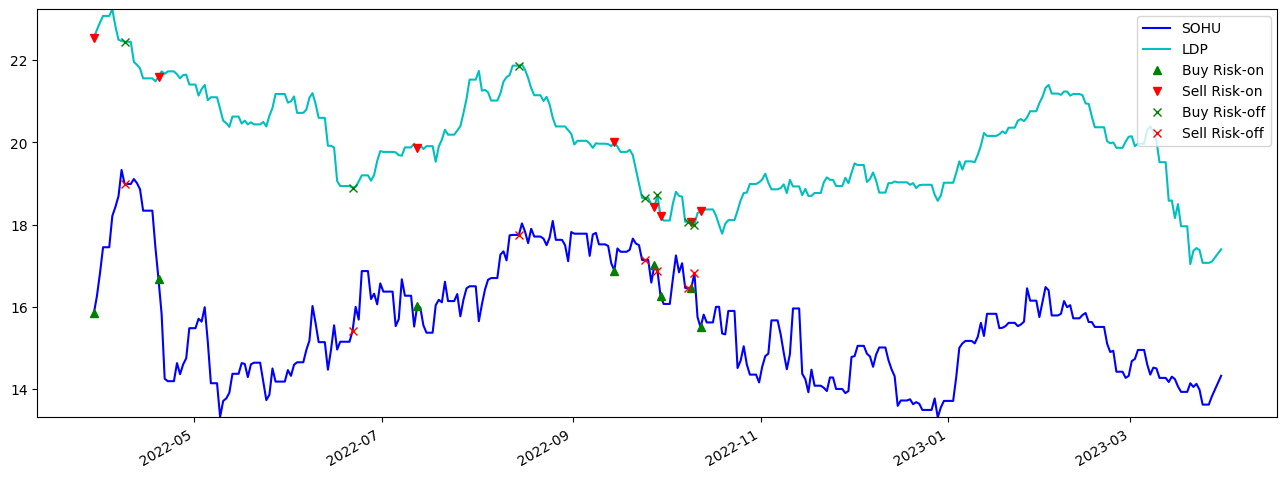

Total reward for this pair: 8.723850921061779
Total return for this pair: 9.384046733711731


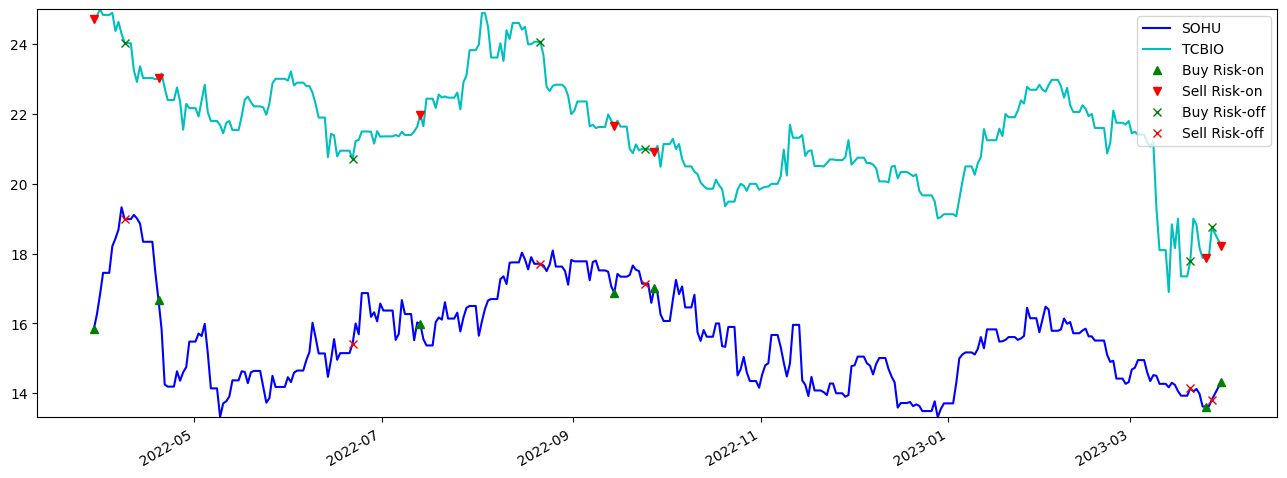

Total reward for this pair: 0.3313101124814533
Total return for this pair: 0.4472263978712268


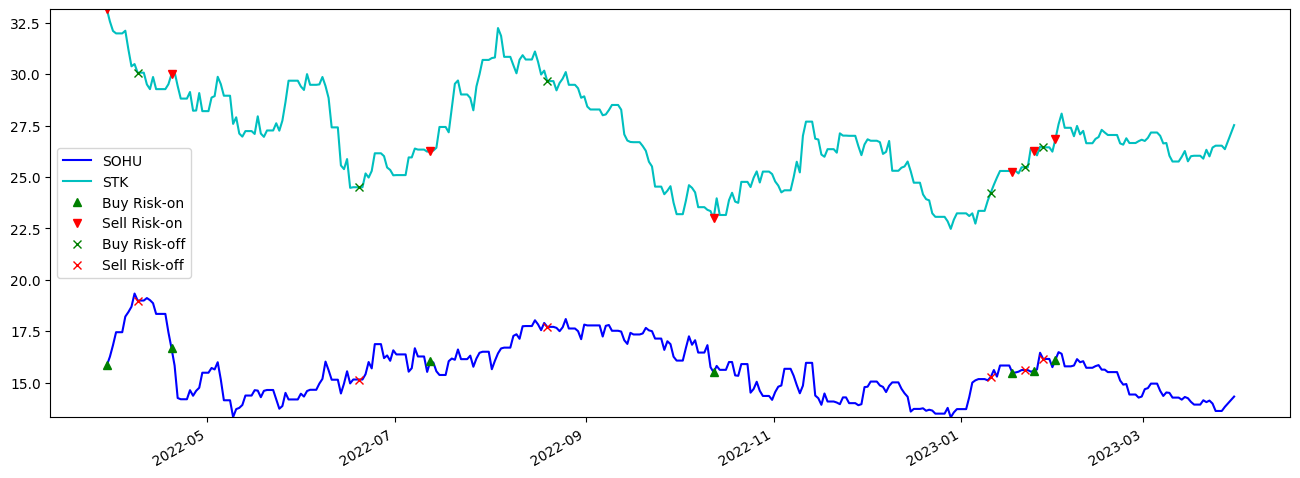

Total reward for this pair: 7.327467581566478
Total return for this pair: 7.697302031187406


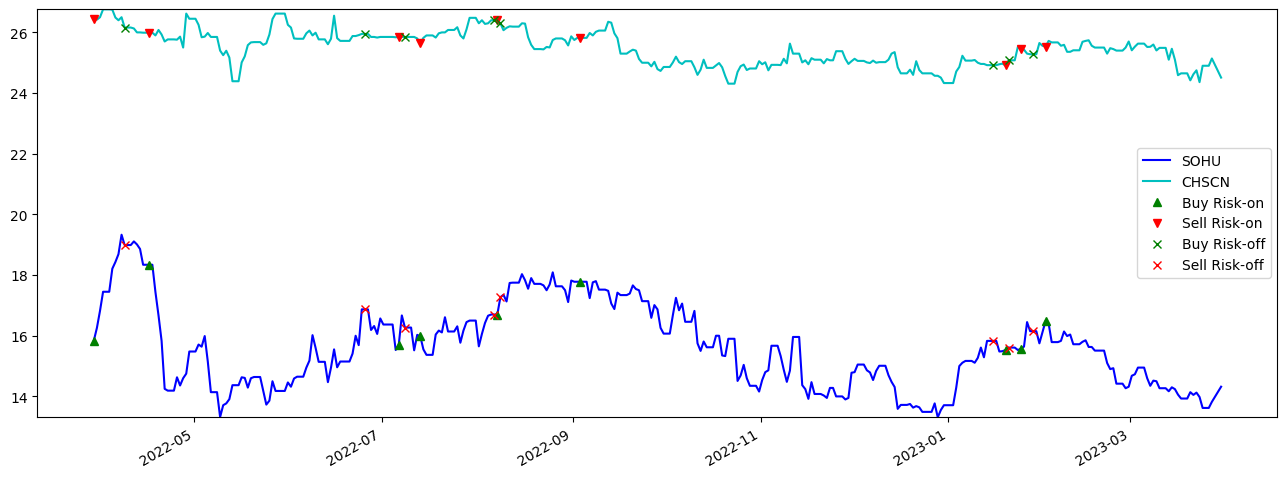

Total reward for this pair: 5.027043724262524
Total return for this pair: 5.604568773376956


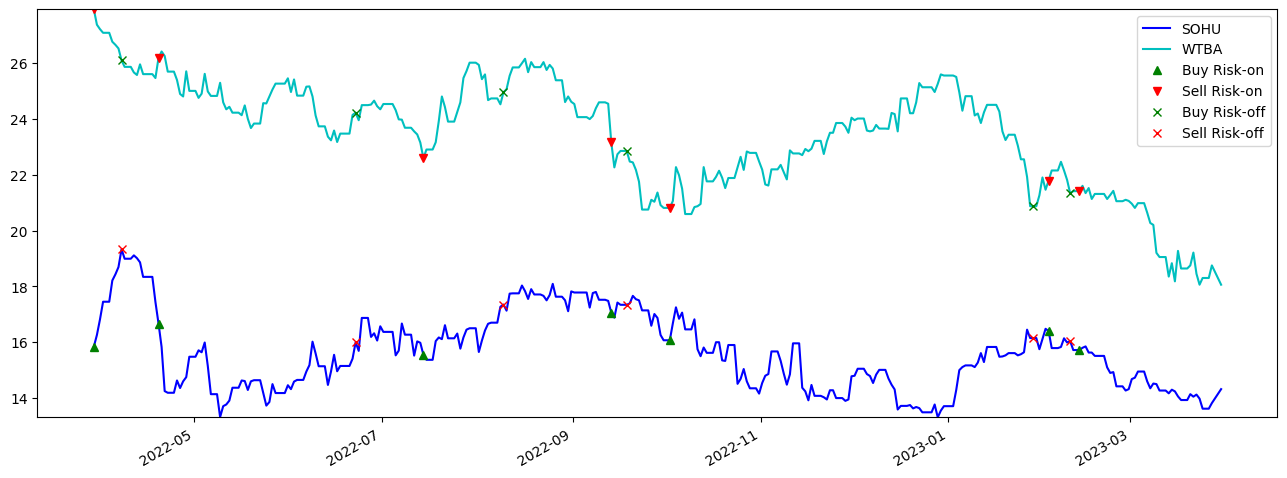

Total reward for this pair: 5.204944783502885
Total return for this pair: 5.596280949739249


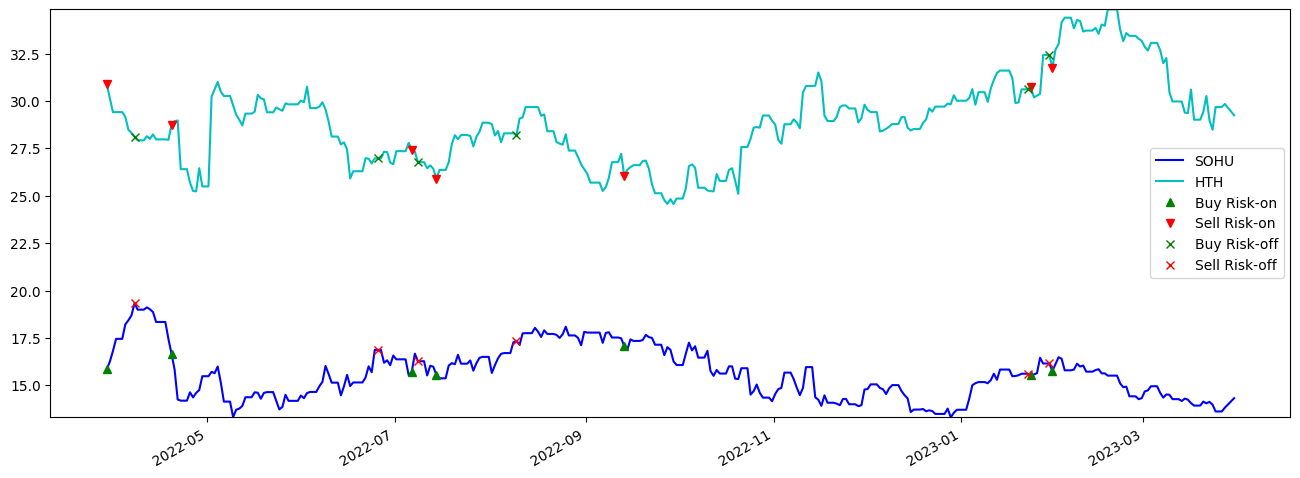

Total reward for this pair: 6.214248153090916
Total return for this pair: 6.847523760199193


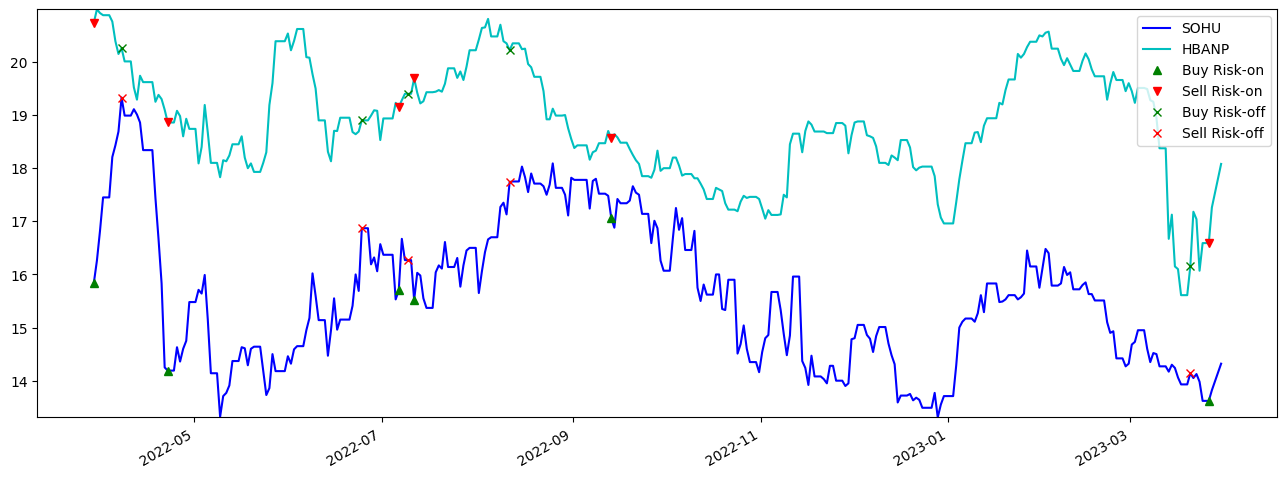

Total reward for this pair: 11.612398822051162
Total return for this pair: 12.02409768719312


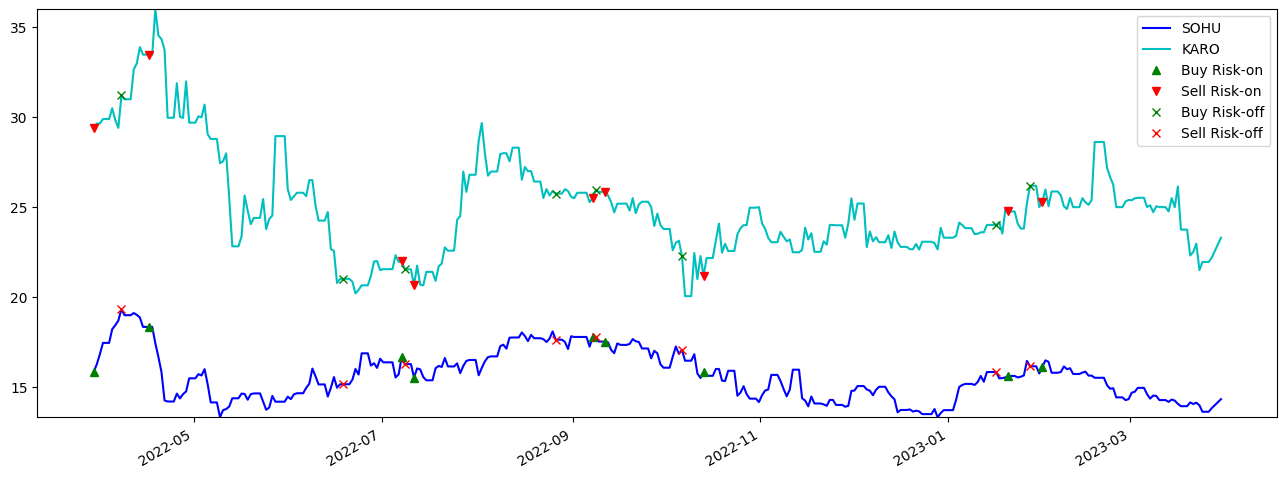

Total reward for this pair: 5.5224815202471
Total return for this pair: 5.783018592775626


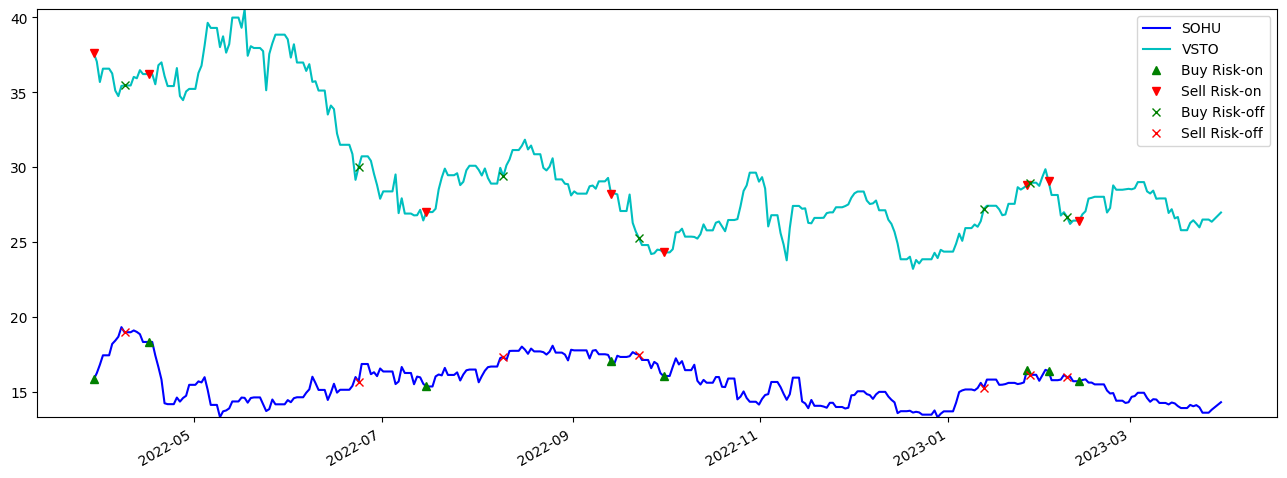

Total reward for this pair: 5.03800578803305
Total return for this pair: 5.218807840360683


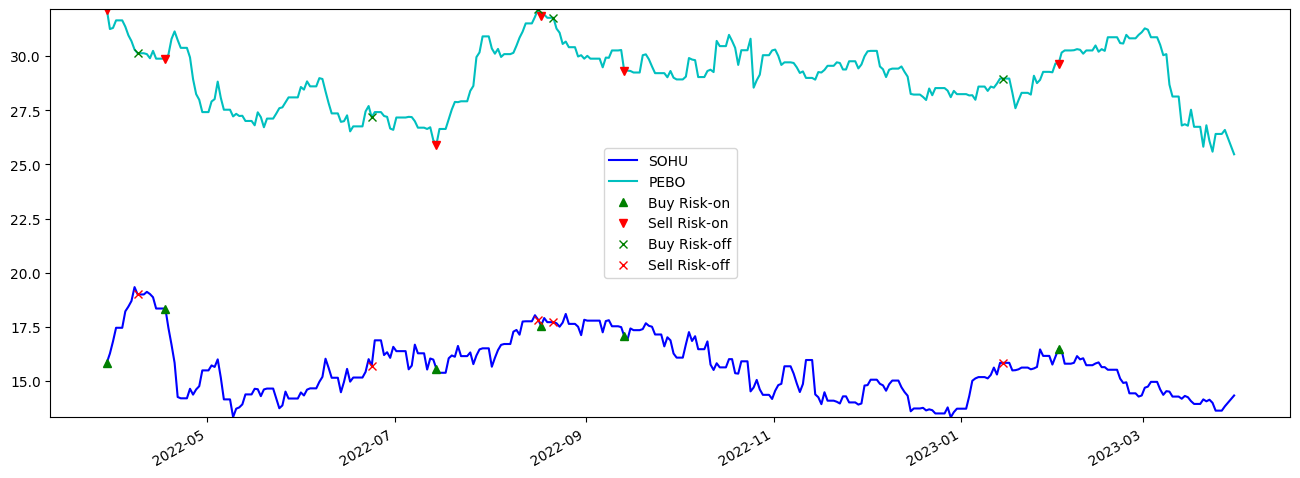

Total reward for this pair: -1.1824582813380384
Total return for this pair: -0.8288426143375709


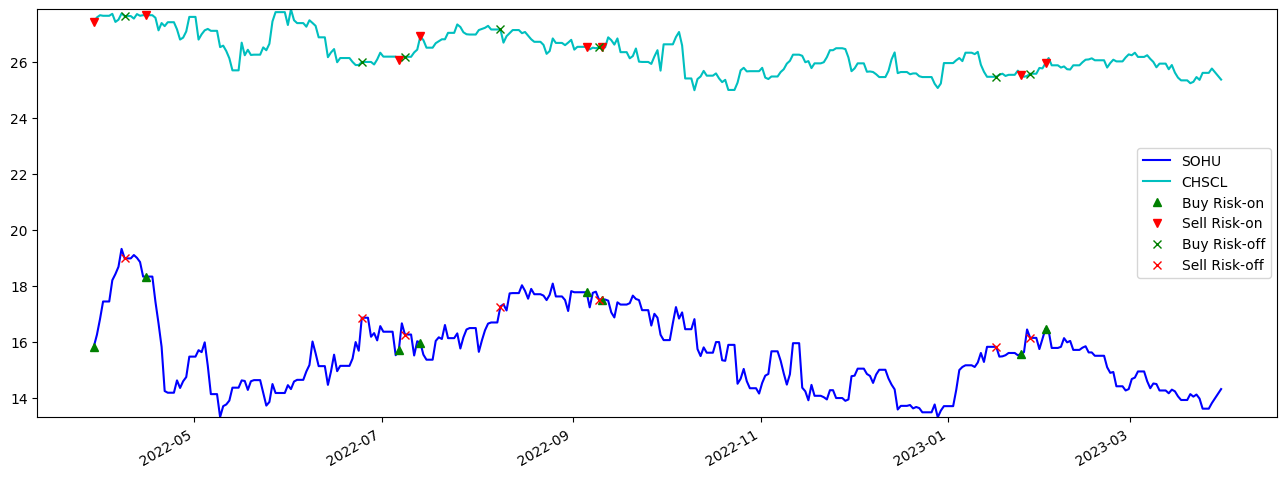

Total reward for this pair: 8.734184990028707
Total return for this pair: 9.214560713080868


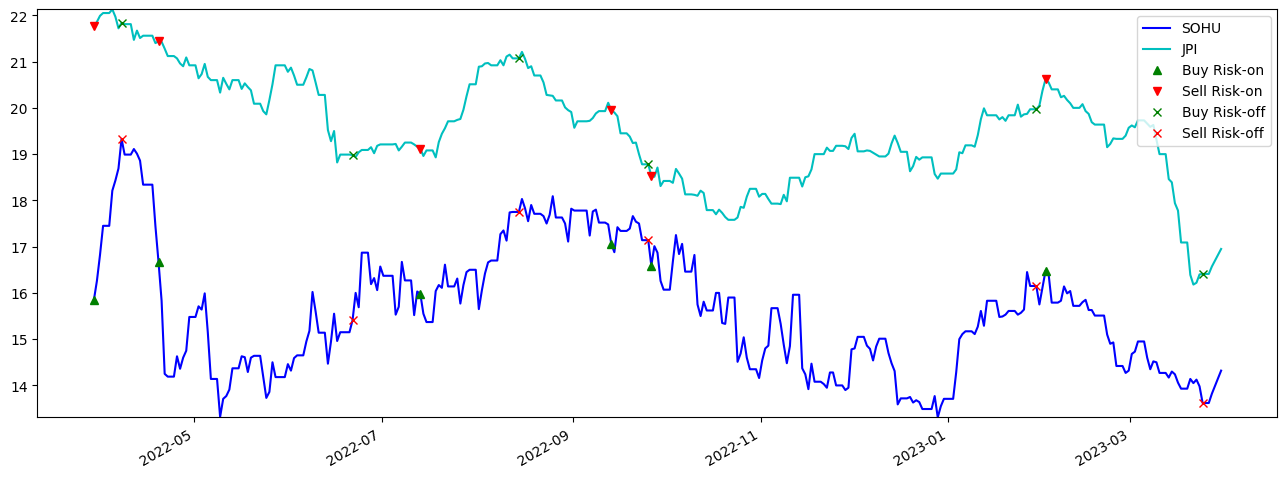

Total reward for this pair: 7.680425451848566
Total return for this pair: 8.056846761775962


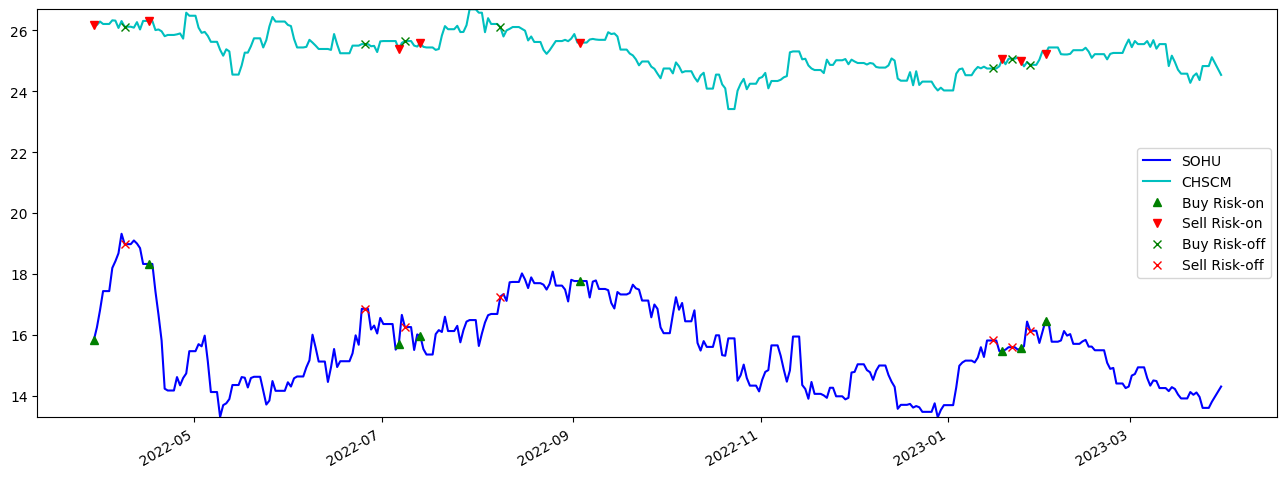

Total reward for this pair: 5.627282869836584
Total return for this pair: 6.139863977653392


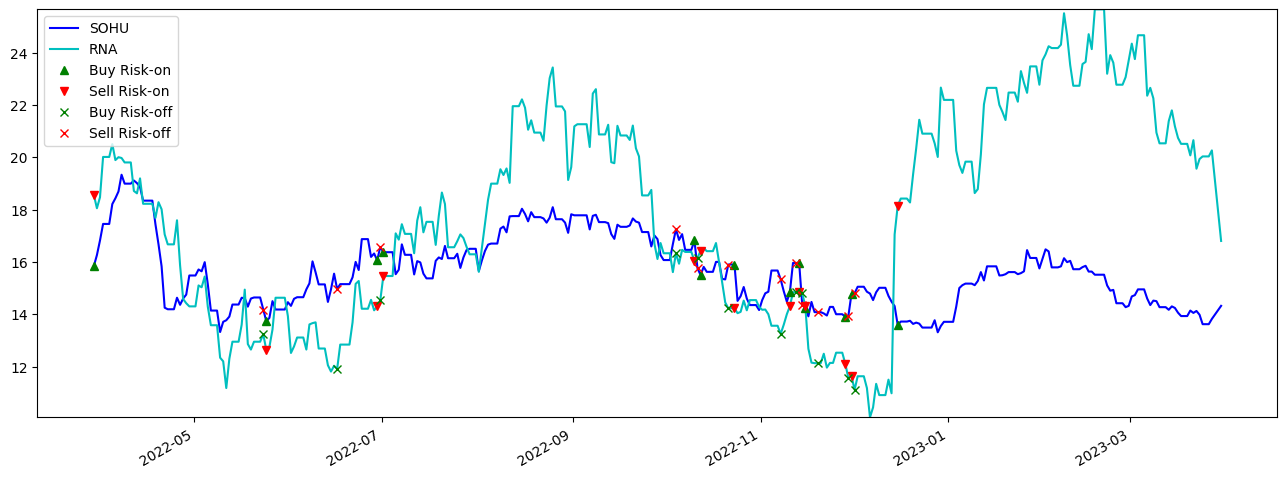

Total reward for this pair: 15.83041900860668
Total return for this pair: 16.78432169249998


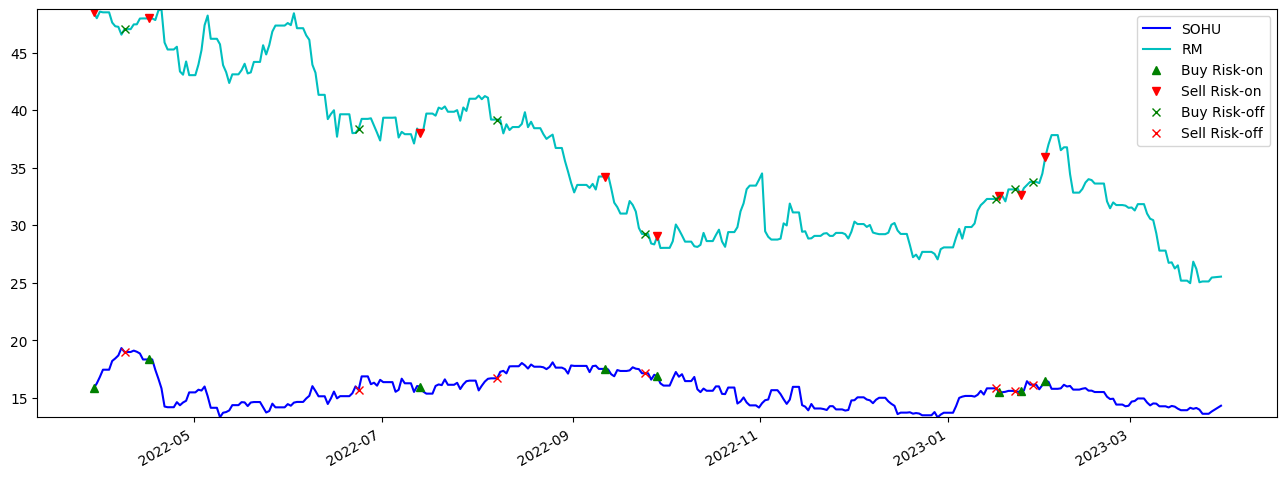

Total reward for this pair: 3.089577748533395
Total return for this pair: 3.70344365171061


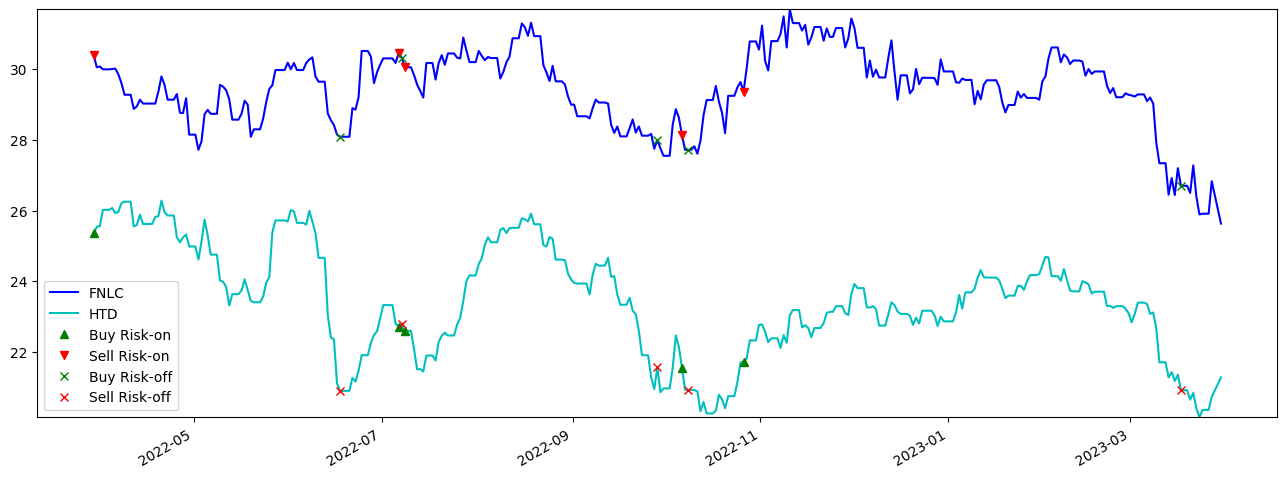

Total reward for this pair: -7.157205070109394
Total return for this pair: -7.01488634262036


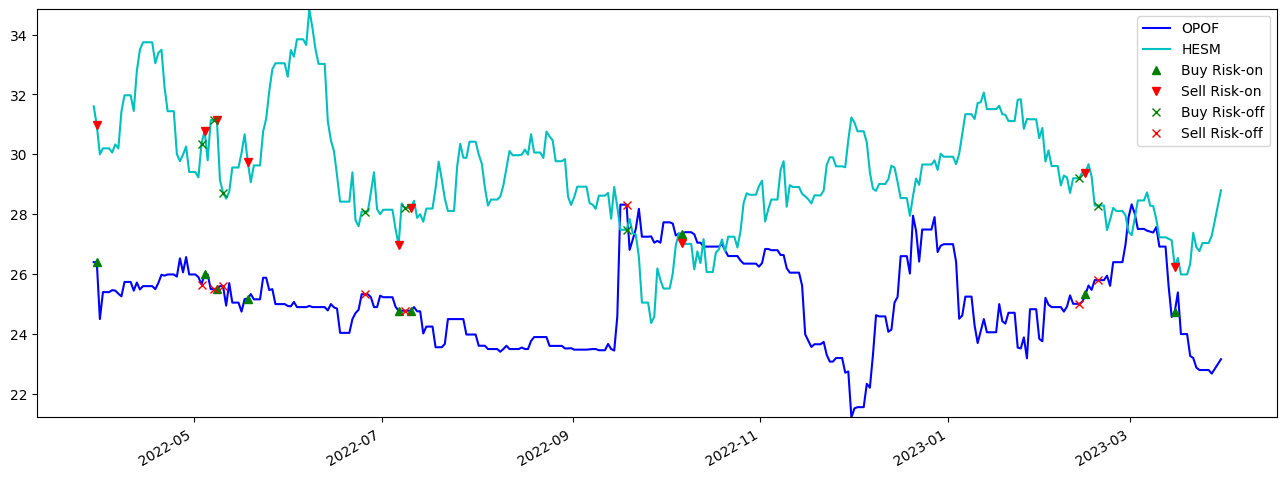

Total reward for this pair: -2.943923765795012
Total return for this pair: -1.9088020606354406


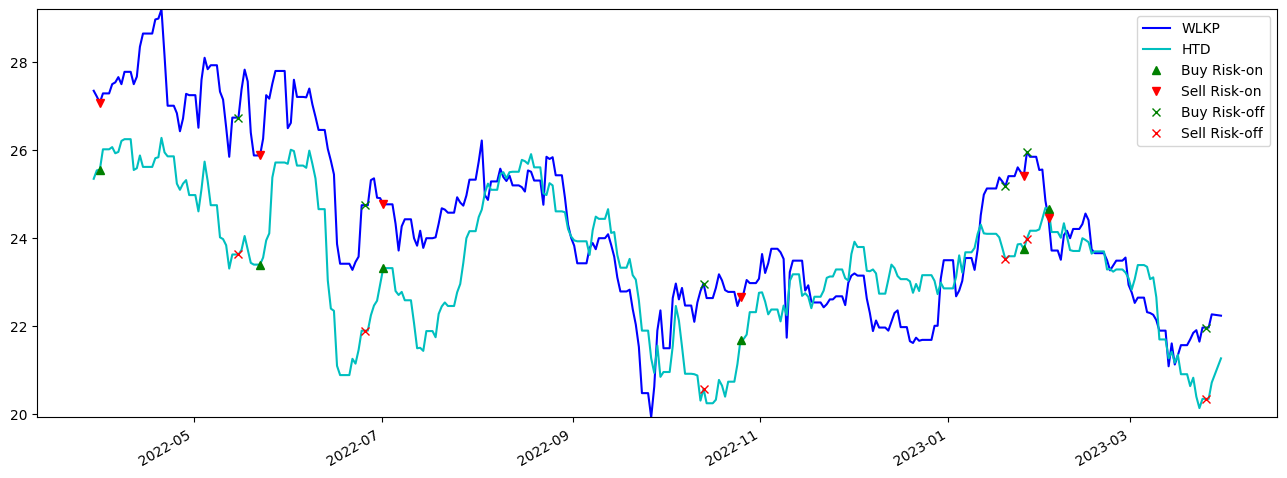

Total reward for this pair: -11.377945332950137
Total return for this pair: -11.095105146540806


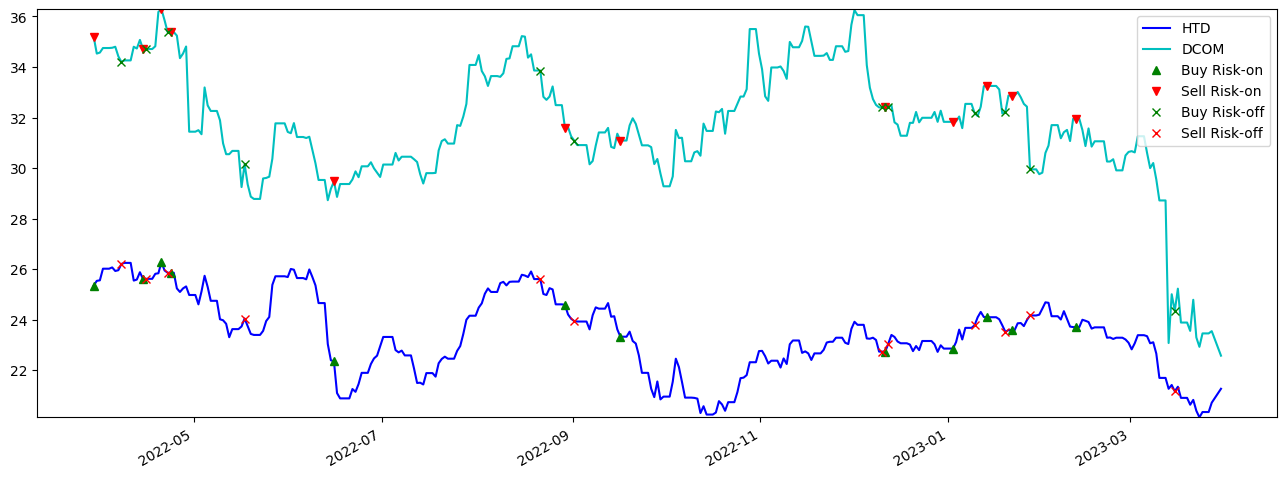

Total reward for this pair: 7.704570788942002
Total return for this pair: 7.914622245375959


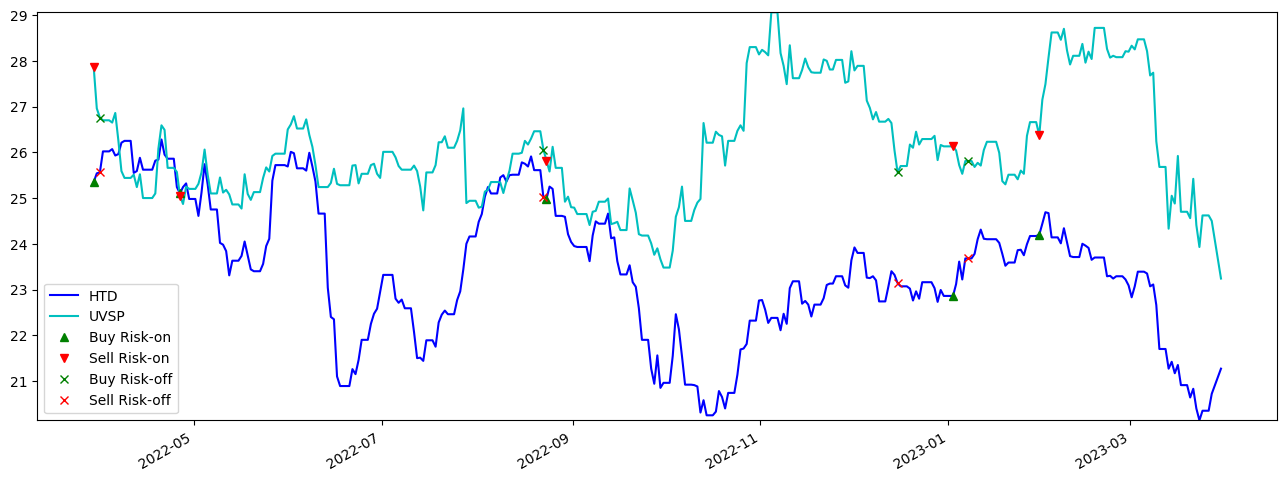

Total reward for this pair: 0.21111949637094662
Total return for this pair: 0.603324959230416


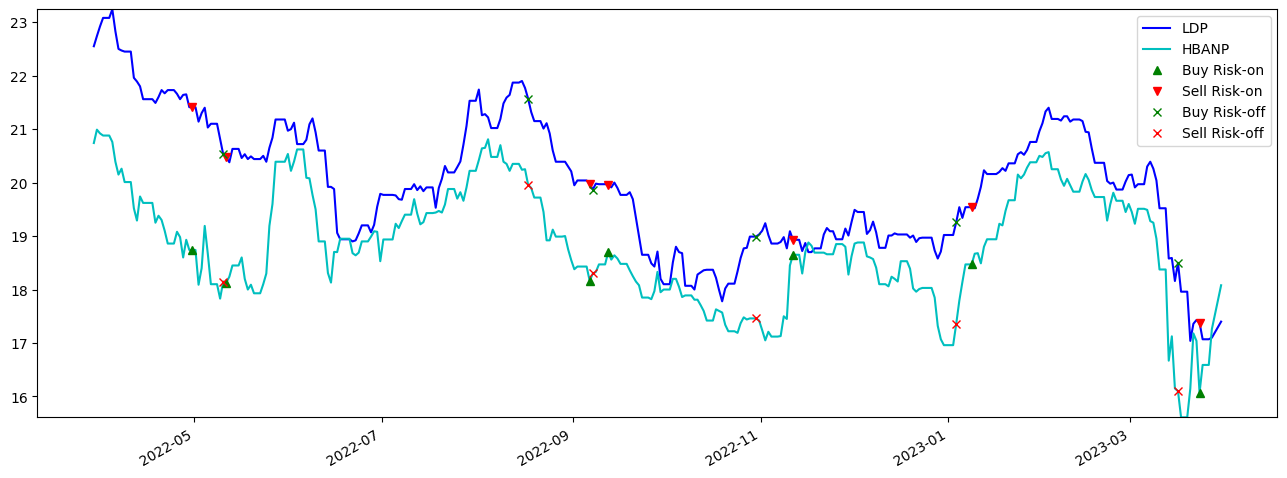

Total reward for this pair: -4.31838141251201
Total return for this pair: -4.1726135991843165


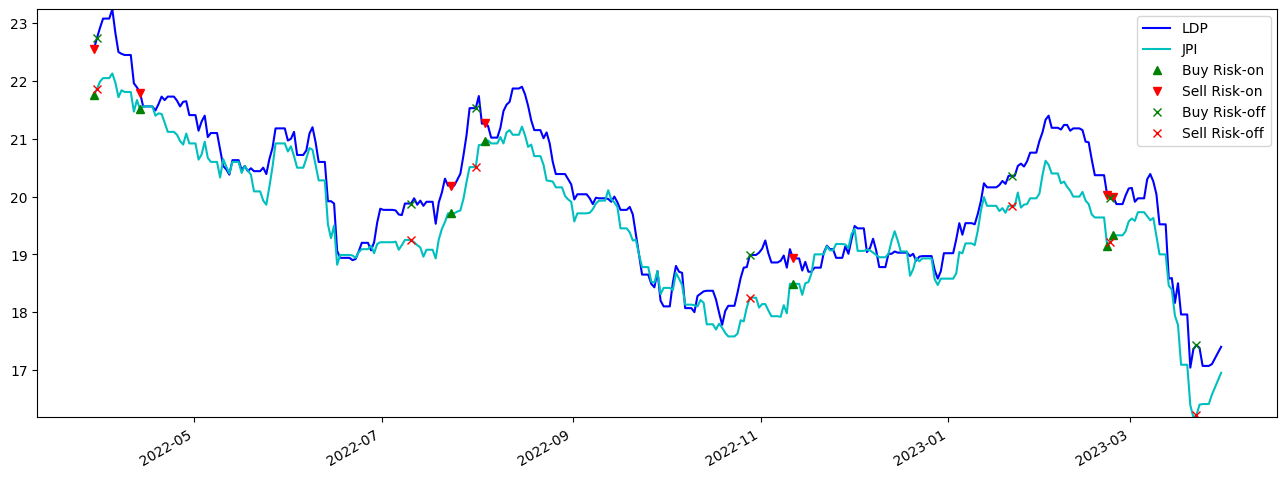

Total reward for this pair: -3.92292088317829
Total return for this pair: -3.8759631565738157


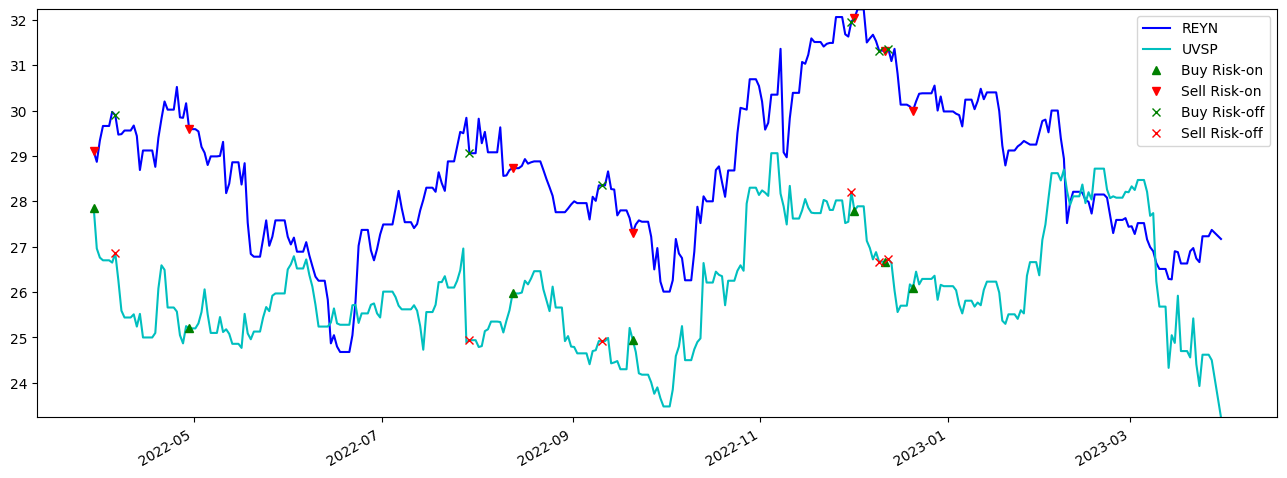

Total reward for this pair: -6.952174173736732
Total return for this pair: -6.699488839132775


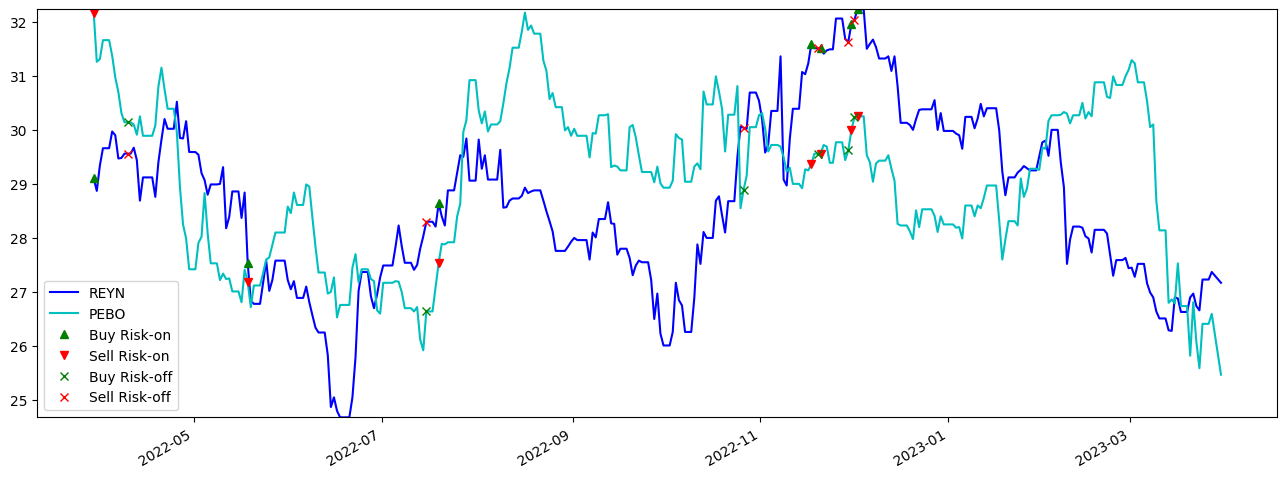

Total reward for this pair: 3.3346469762525
Total return for this pair: 3.73679111491258


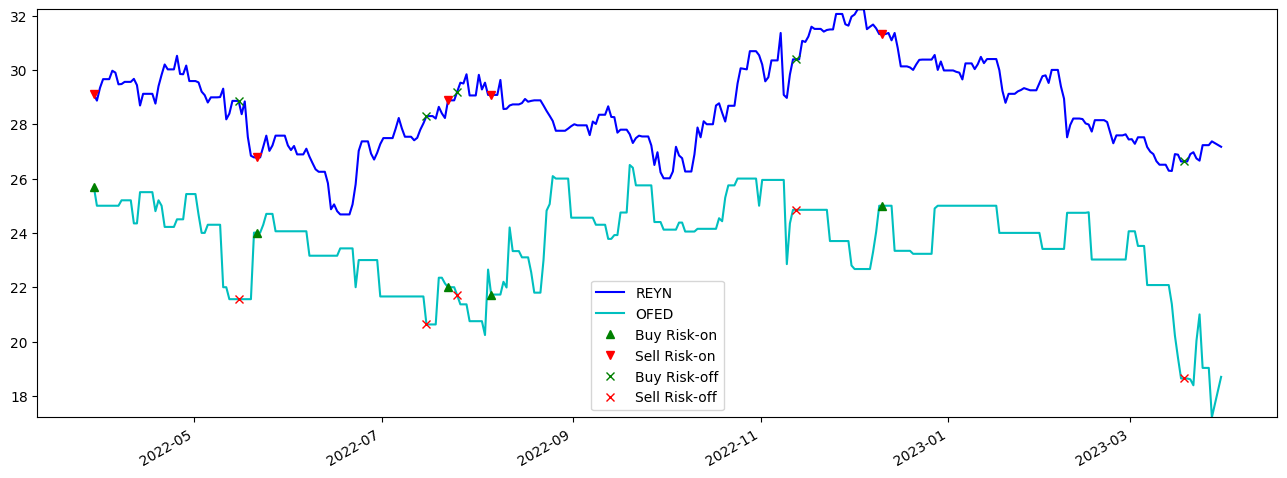

Total reward for this pair: -14.80906283149757
Total return for this pair: -14.752951219436966


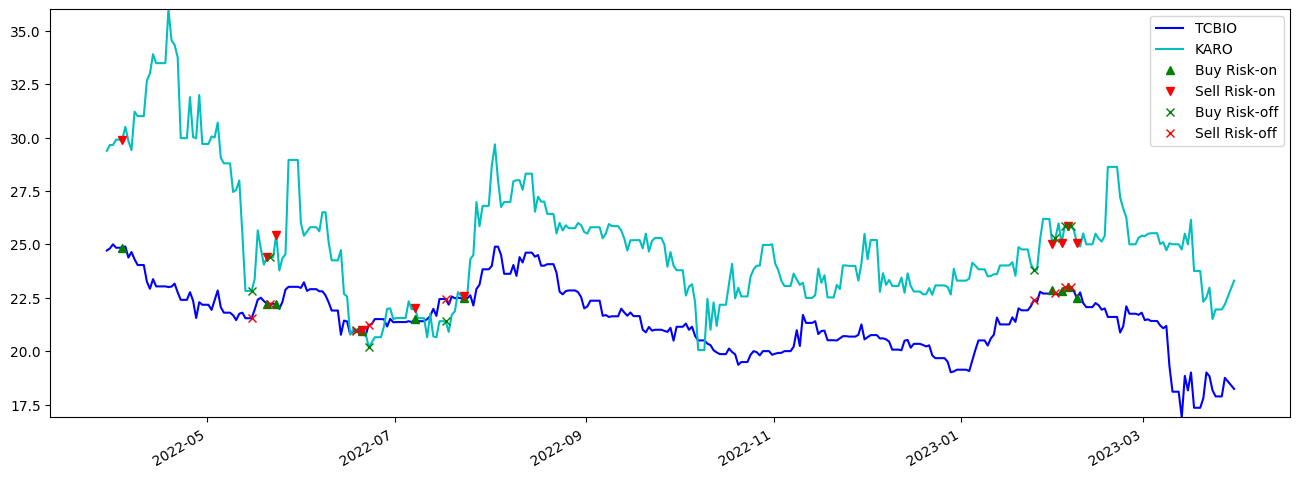

Total reward for this pair: 13.653112561867305
Total return for this pair: 14.21458991450611


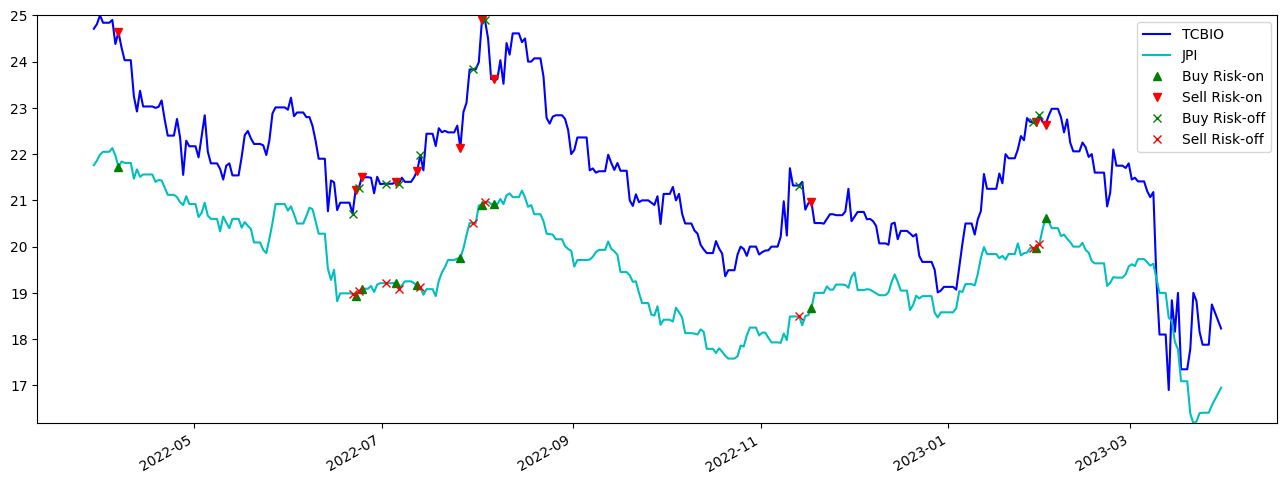

Total reward for this pair: -4.267507918041982
Total return for this pair: -3.930989320852328


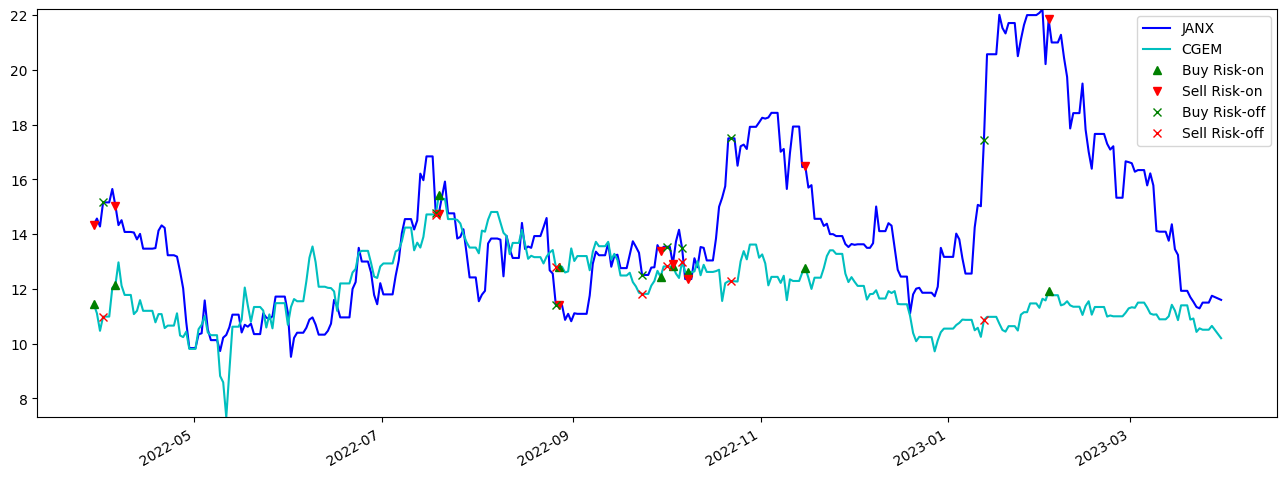

Total reward for this pair: -18.9070174527395
Total return for this pair: -17.8480966020263


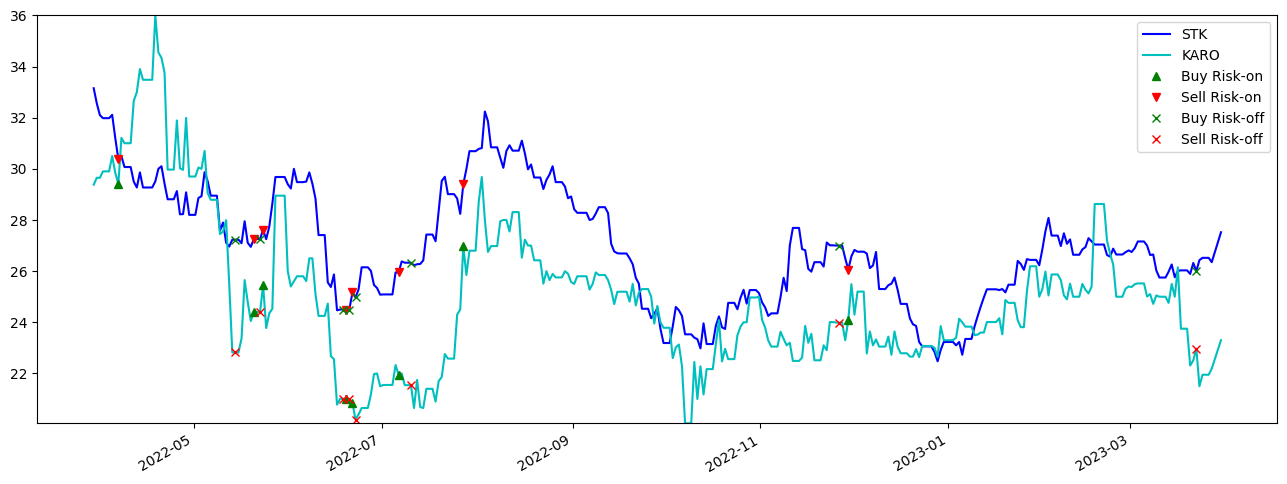

Total reward for this pair: -16.759018311567903
Total return for this pair: -16.316602488978127


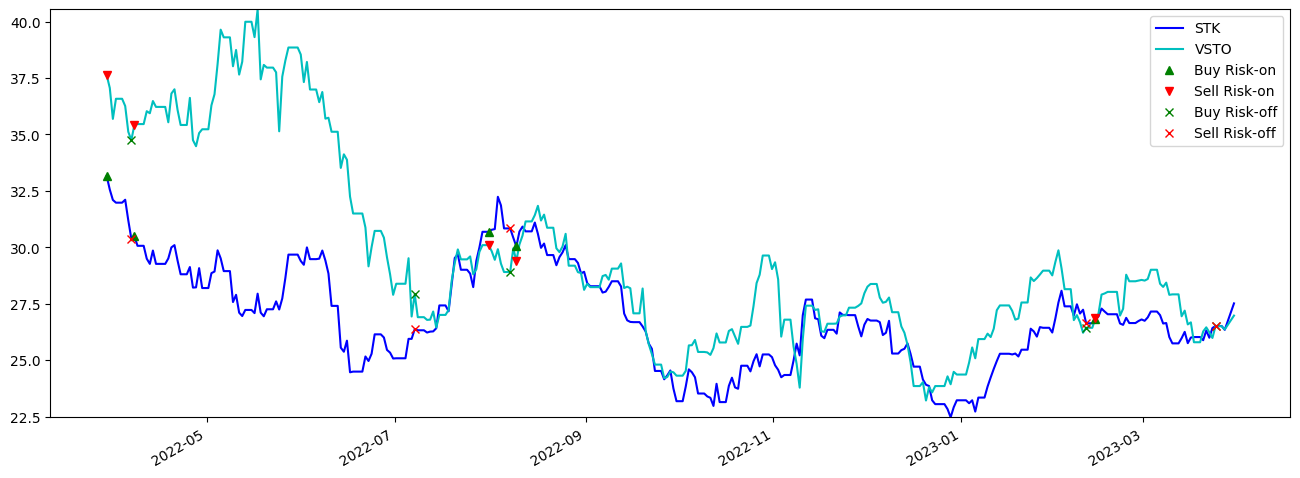

Total reward for this pair: 6.468494121639057
Total return for this pair: 7.269846834985323


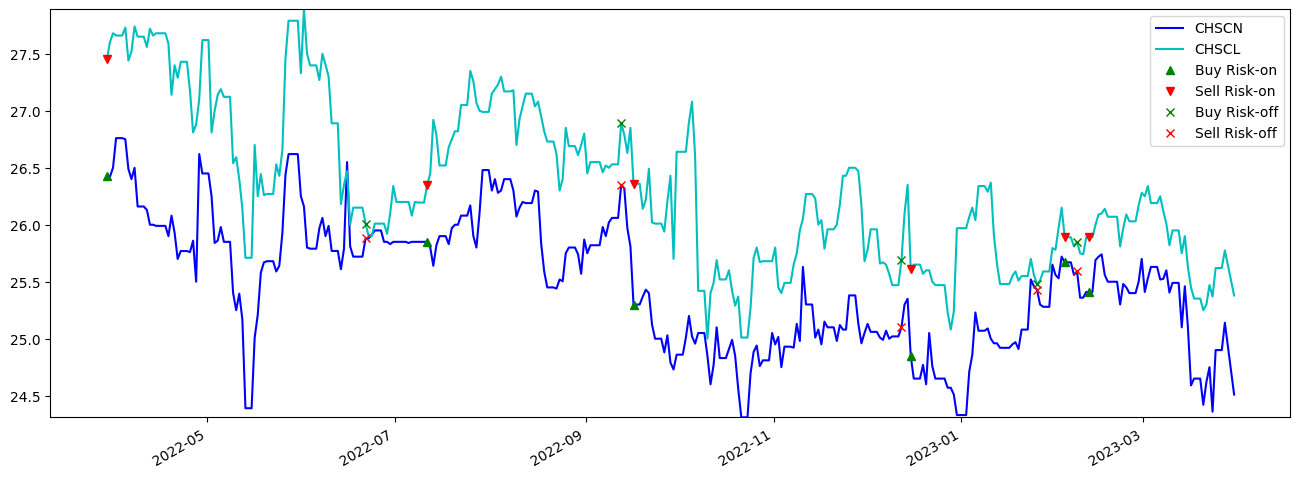

Total reward for this pair: 2.6409723792424527
Total return for this pair: 2.7244312362506955


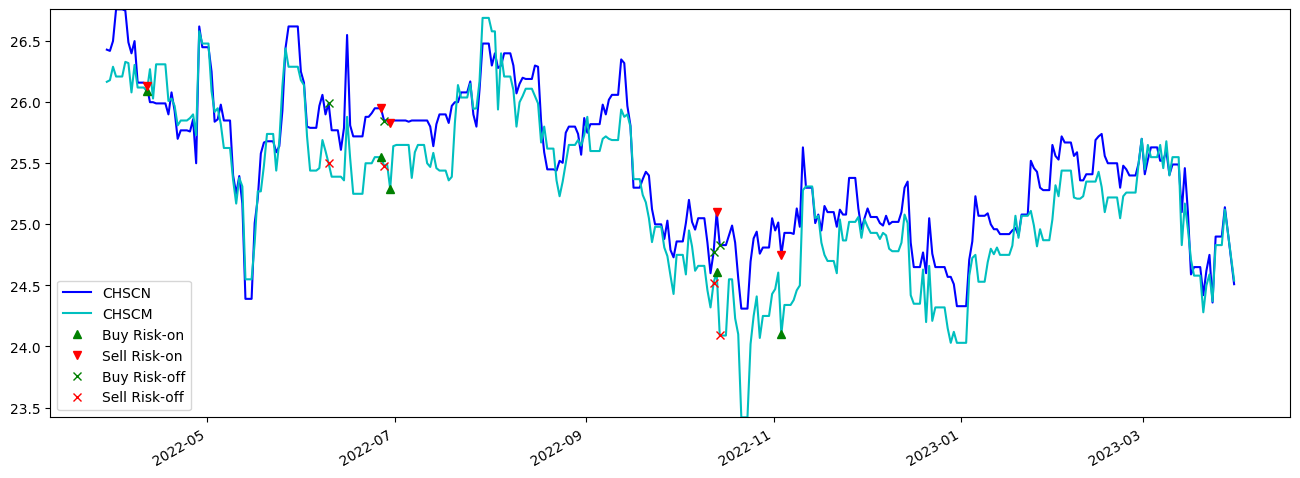

Total reward for this pair: -1.5602319766797912
Total return for this pair: -1.4761006778815864


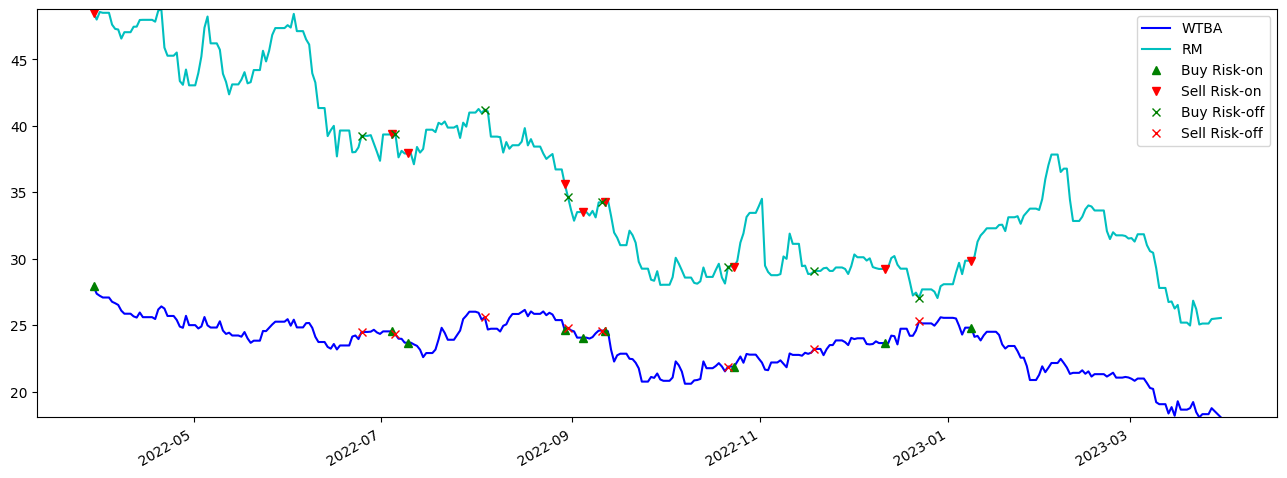

Total reward for this pair: 2.9779588997458077
Total return for this pair: 3.547605171124938


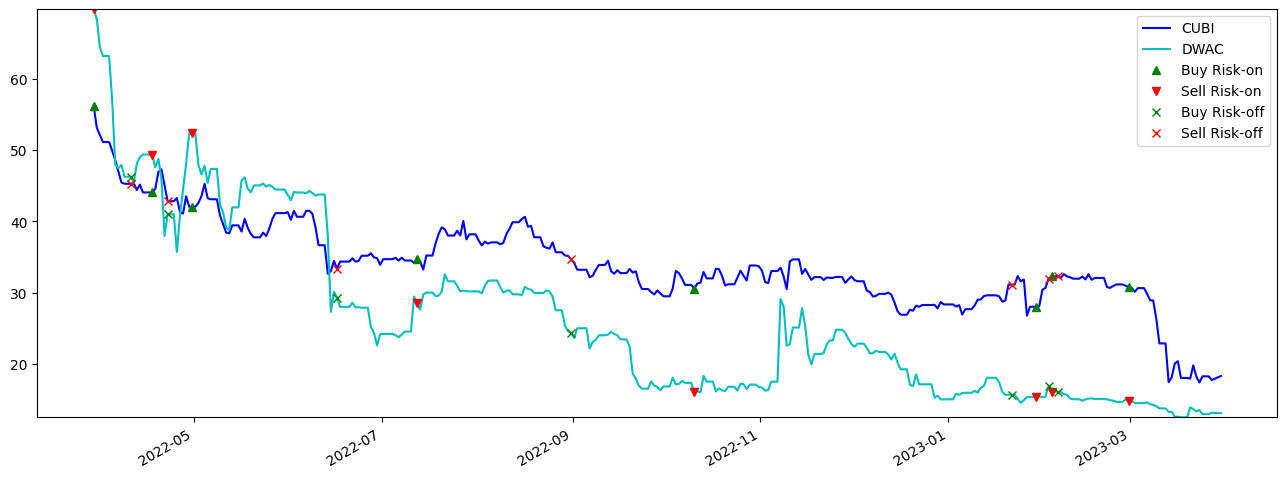

Total reward for this pair: 36.161458536313546
Total return for this pair: 36.912034172288216


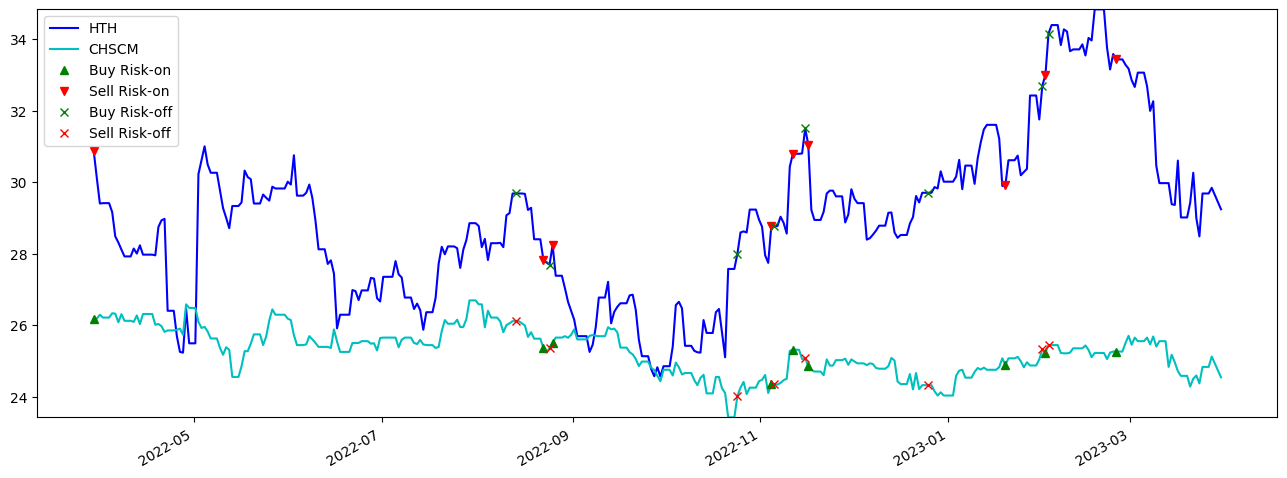

Total reward for this pair: -6.851397079188878
Total return for this pair: -6.230221540100975


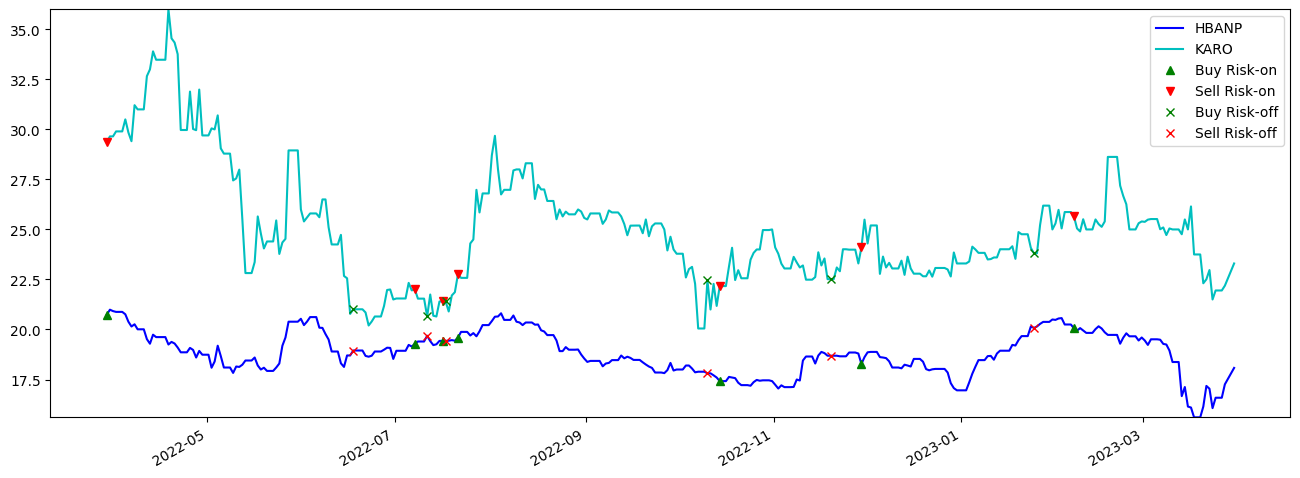

Total reward for this pair: 5.003140206856398
Total return for this pair: 5.282521969806041


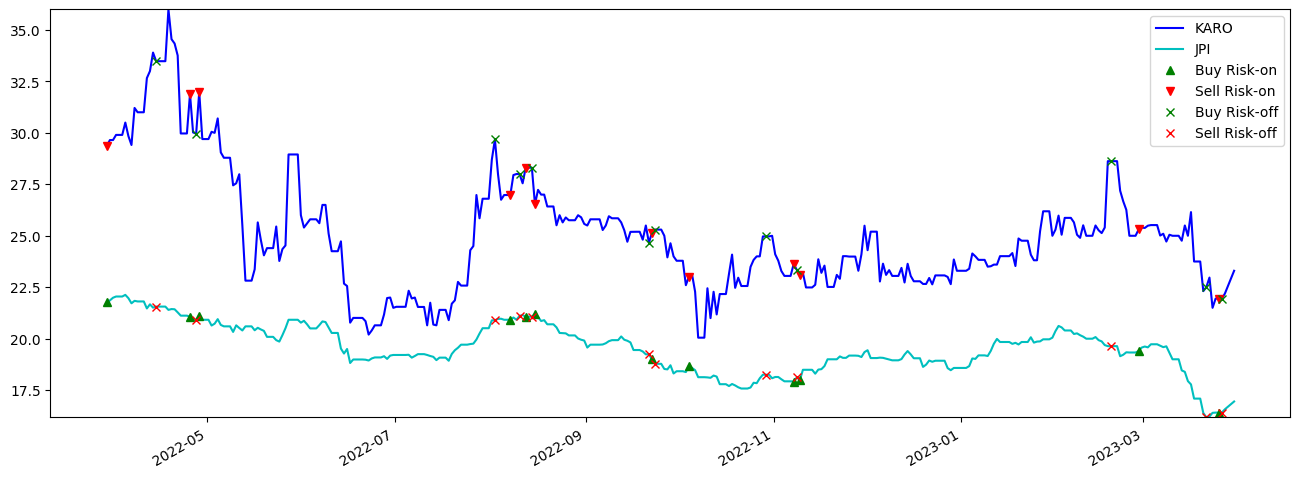

Total reward for this pair: -14.743737302838571
Total return for this pair: -13.476147162279506


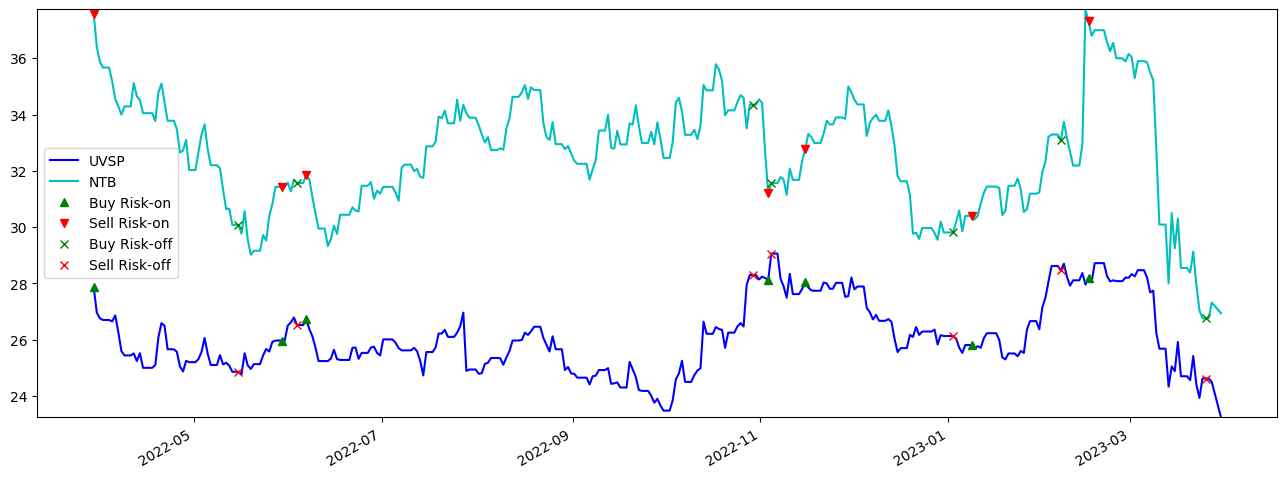

Total reward for this pair: 8.899256270044418
Total return for this pair: 9.059611807689933


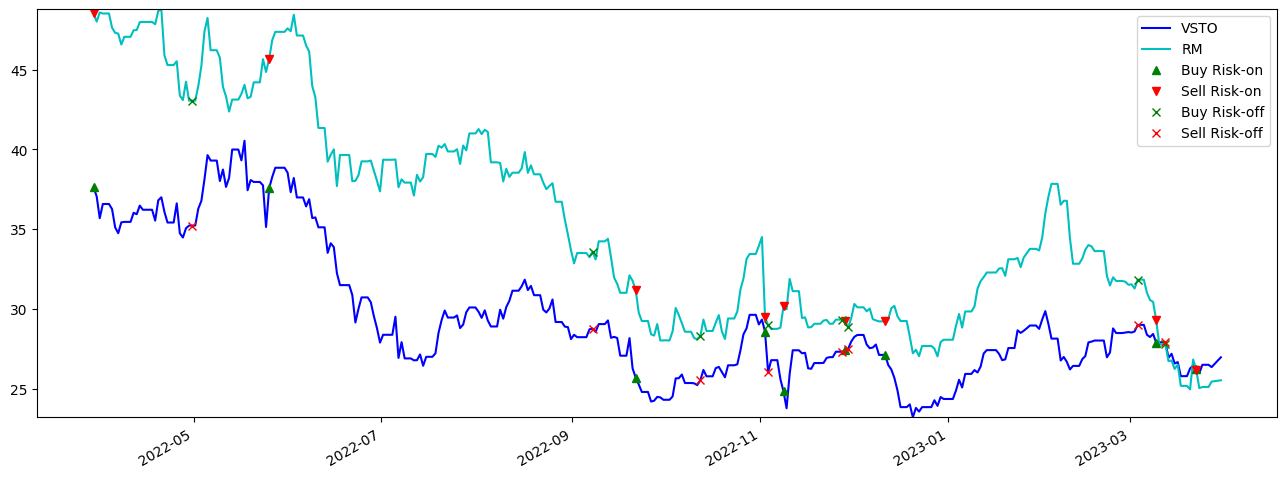

Total reward for this pair: 13.993871324432353
Total return for this pair: 14.818918607158228


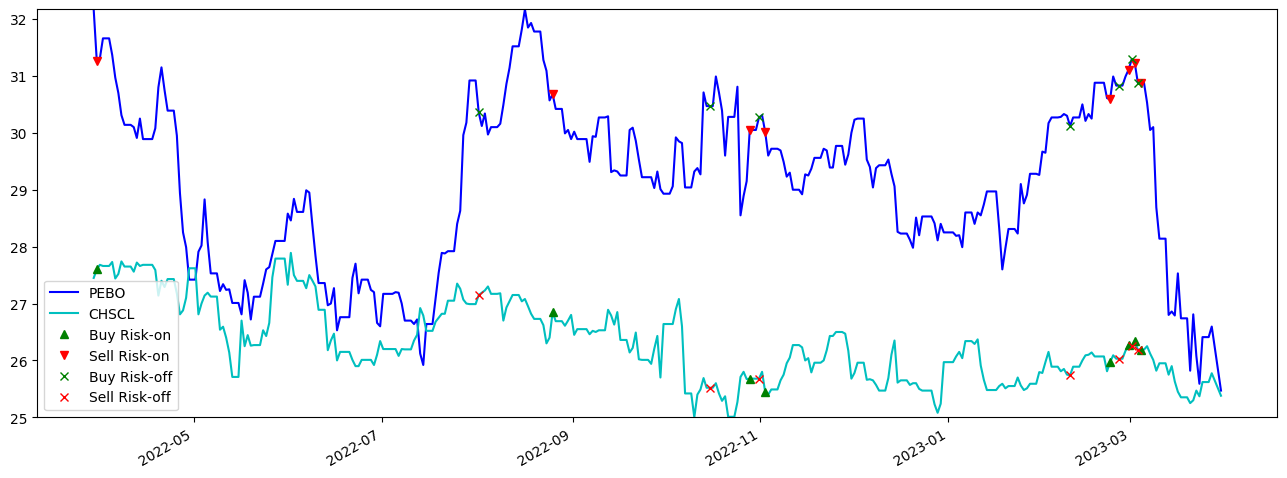

Total reward for this pair: -3.6599667696342135
Total return for this pair: -3.4617299260768486


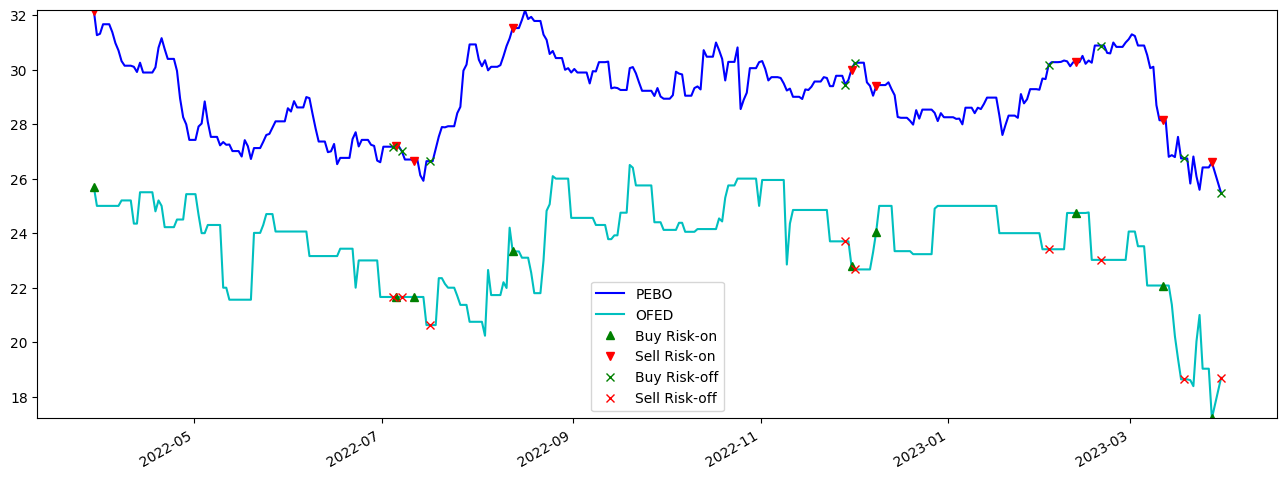

Total reward for this pair: -11.909753798573133
Total return for this pair: -10.996695159836907


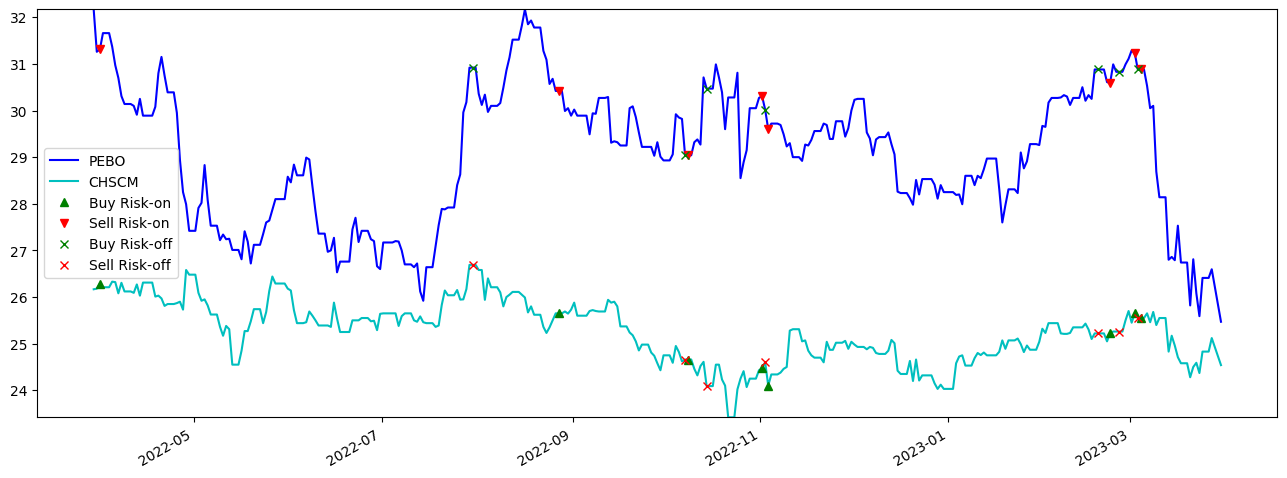

Total reward for this pair: -4.6037880562909494
Total return for this pair: -4.2544812871151505


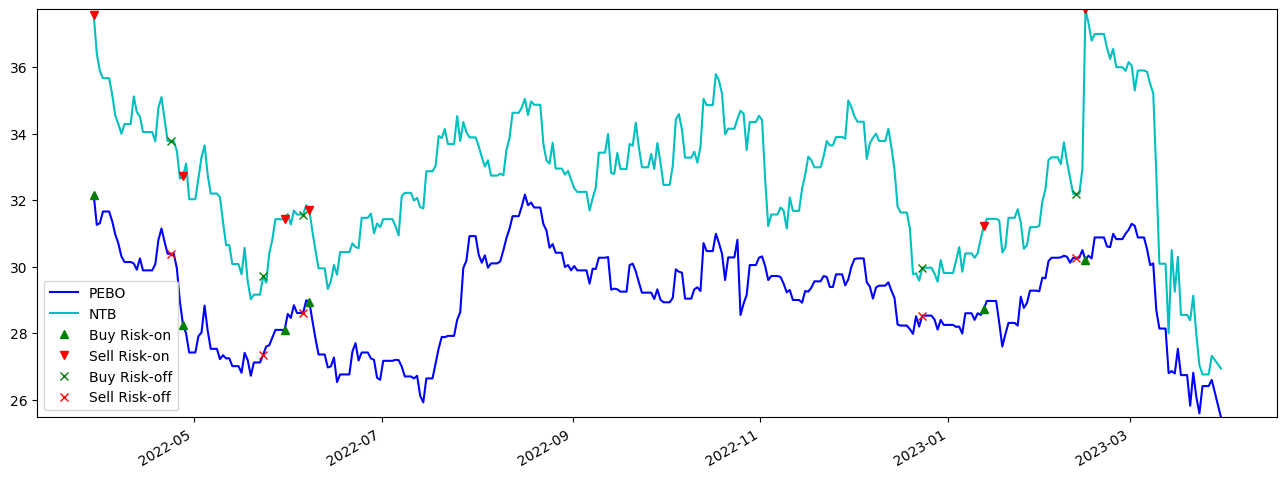

Total reward for this pair: 6.426179592829477
Total return for this pair: 6.664195601324061


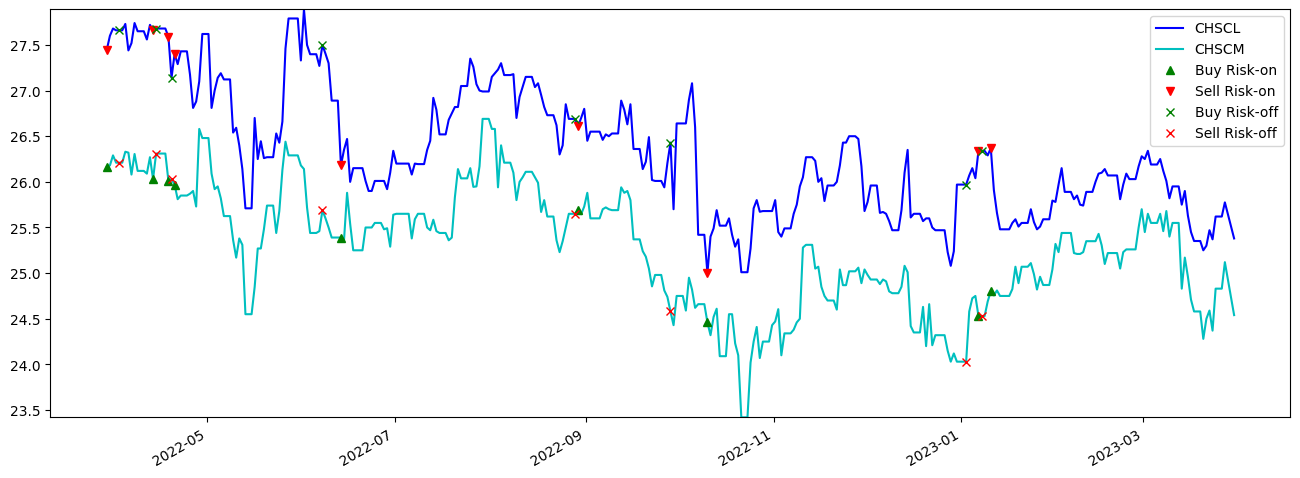

Total reward for this pair: -6.419226112170501
Total return for this pair: -6.102020661147805


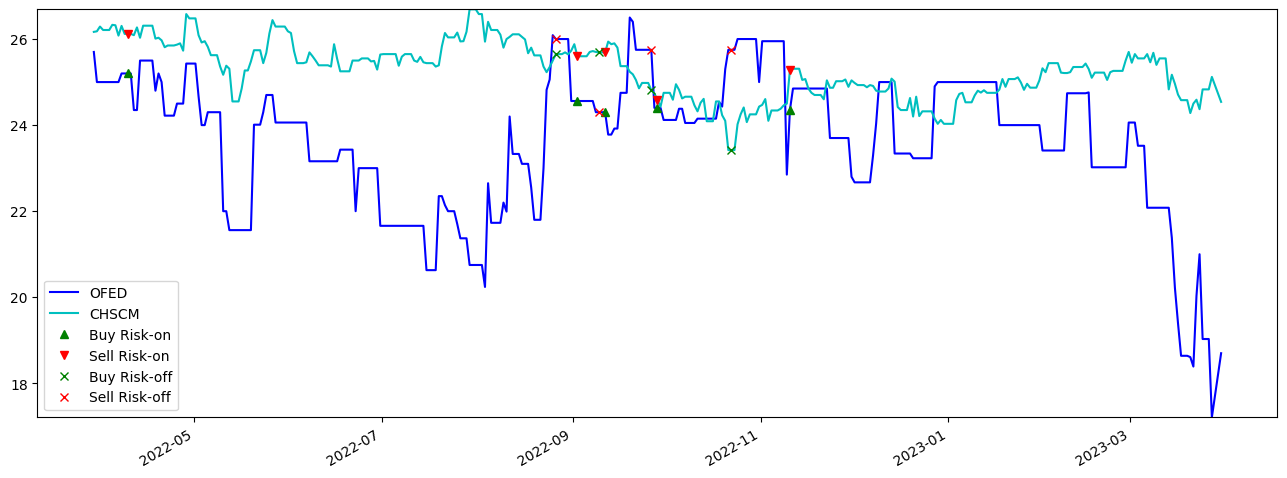

Total reward for this pair: 4.914966256213116
Total return for this pair: 5.374668153849662


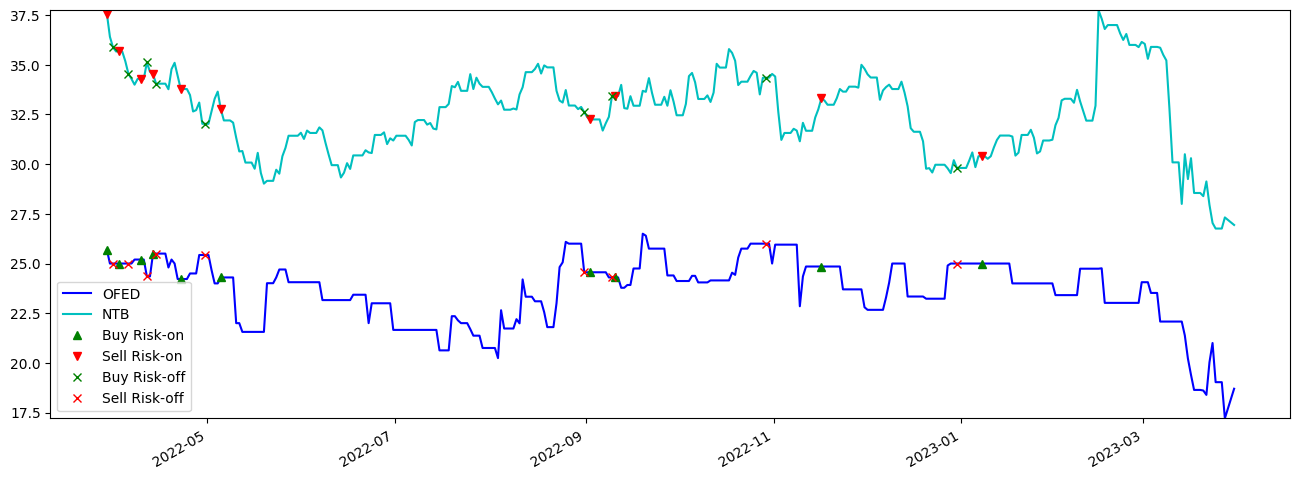

Total reward for this pair: 4.180498484176132
Total return for this pair: 5.1362374954302705
Average overall rewards: 1.5258298008963949
Average overall returns: 1.9852080661371925


In [78]:
#plot entries/exits on val data
#fill in latest/best model
policy_net.load_state_dict(torch.load('./models/model (68).pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

plot.plotEntryExits(policy_net, target_net, valenvs, device)

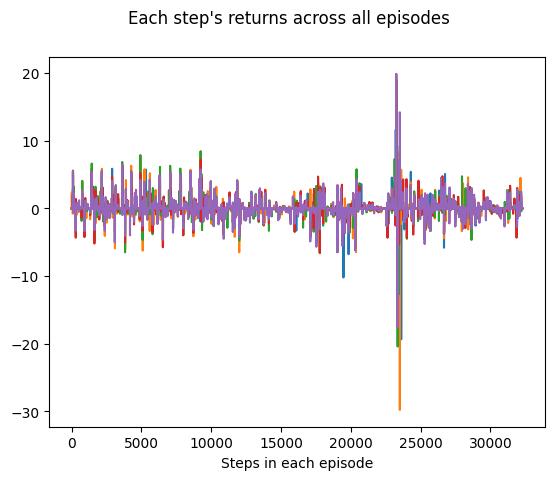

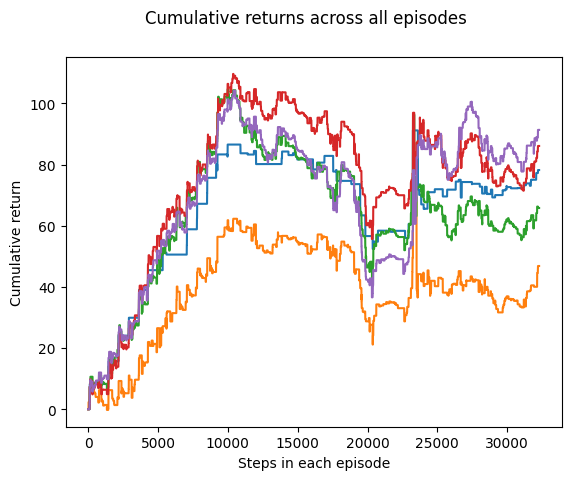

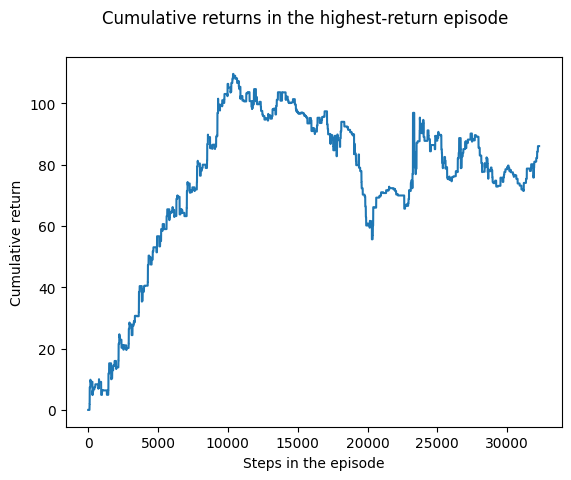

Highest cumulative return in epoch 3, return: 86.06201846688974


In [28]:
plot.plot_episodes(val_return_dict)

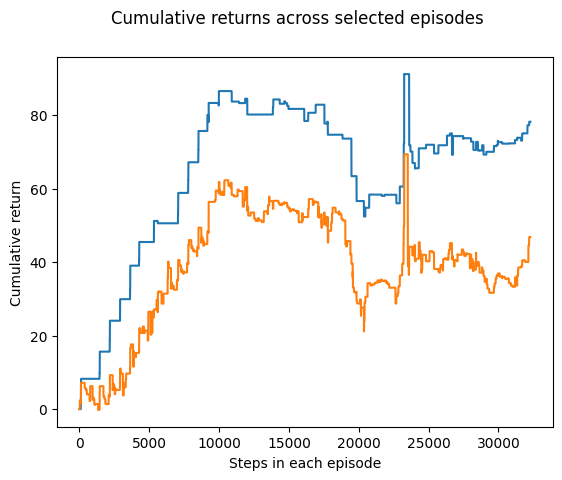

Highest cumulative return in epoch 0, return: 78.19279698050694.


0         1
0       0.000000   0.00000
1       0.000000   0.00000
2       0.000000   0.00000
3       0.000000   0.00000
4       0.000000   0.00000
...          ...       ...
32284  78.192797  46.82378
32285  78.192797  46.82378
32286  78.192797  46.82378
32287  78.192797  46.82378
32288  78.192797  46.82378

[32289 rows x 2 columns]

In [38]:
plot.plot_n_episodes(val_return_dict, 0, 2)

# APPLYING BEST MODEL ON UNSEEN DATA #

In [39]:
#revisit how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 306 stocks
cluster 1: 14 stocks
cluster 3: 24 stocks
cluster 5: 74 stocks
cluster 6: 70 stocks
cluster 8: 403 stocks
cluster 9: 198 stocks


In [40]:
#function to get cluster performance in the testenv of an unseen cluster
def get_cluster_performance(policy_net, target_net, testenvs):
    policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
    target_net.eval()

    total_rewards = []
    total_returns = []
    with torch.no_grad():
        for testenv in testenvs:
            obs = testenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)
                obs, _reward, done, info, _return = testenv.step(Positions(action.item()))
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
                
                if done:
                    total_rewards.append(info['total_reward'])
                    total_returns.append(info['total_return'])
                    break

    cluster_rewards = np.mean(total_rewards)
    cluster_returns = np.mean(total_returns)

    return cluster_rewards, cluster_returns

In [73]:
#find overall performance on all good and unseen clusters
def unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    overall_rewards = []
    overall_returns = []

    for i in good_clusters_dict.keys():
        #choose cluster of a reasonable size as test cluster
        dailyDF_test = dailyDF[good_clusters_dict[i]]

        #no need to plot heatmap; just to get the testpairs, testpval, testdf,
        testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))
        print(f'Cluster {i} has {len(testpairs)} testpairs.')

        #create testenvs
        testenvs = []
        for testpair in testpairs:
            testdata = testdf[list(testpair)].dropna()
            if testdata.shape[0] > 250:
                #instantiate an env; automatatically run trade()
                testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, trade_period, transaction_cost))

        #get cluster performance
        cluster_rewards, cluster_returns = get_cluster_performance(policy_net, target_net, testenvs)
        print(f'For cluster {i}, overall reward is {cluster_rewards}, overall return is {cluster_returns}')

        overall_rewards.append(cluster_rewards)
        overall_returns.append(cluster_returns)
    
    print(f'For all clusters, total reward is {np.sum(overall_rewards)}, total return is {np.sum(overall_returns)}.')
    print(f'Average reward is {np.mean(overall_rewards)}, average return is {np.mean(overall_returns)}.')
        

In [52]:
#Average out all unseen clusters n times
def avg_n_performance(n, good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    avg_n_rewards = []
    avg_n_returns = []

    for e in range(n):

        ep_rewards = []
        ep_returns = []
        
        #loop through each good cluster
        for i in good_clusters_dict.keys():
            dailyDF_test = dailyDF[good_clusters_dict[i]]

            #no need to plot heatmap; just to get the testpairs, testpval, testdf,
            testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))

            #create testenvs
            testenvs = []
            for testpair in testpairs:
                testdata = testdf[list(testpair)].dropna()
                if testdata.shape[0] > 250:
                    #instantiate an env; automatatically run trade()
                    testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, trade_period, transaction_cost))

            #get cluster performance
            cluster_rewards, cluster_returns = get_cluster_performance(policy_net, target_net, testenvs)
            
            ep_rewards.append(cluster_rewards)
            ep_returns.append(cluster_returns)
        
        avg_n_rewards.append(np.mean(ep_rewards))
        avg_n_returns.append(np.mean(ep_returns))
    
    #Plot all cumulative sums
    sns.lineplot(data=avg_n_rewards, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing average rewards across all clusters')
    plt.xlabel('Iterations')
    plt.ylabel('Average rewards')
    plt.show()

    sns.lineplot(data=avg_n_returns, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing average returns across all clusters')
    plt.xlabel('Iterations')
    plt.ylabel('Average returns')
    plt.show()

    print(f'The average rewards and returns after {n} iterations are respectively {np.mean(avg_n_rewards)} and {np.mean(avg_n_returns)}.')
        

In [74]:
#One iteration of performance of all clusters
unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)

Cluster 0 has 24 testpairs.
For cluster 0, overall reward is -0.5557946206303775, overall return is -0.28570558042675015
Cluster 1 has 12 testpairs.
For cluster 1, overall reward is 5.000461891397864, overall return is 5.304056330690468
Cluster 3 has 17 testpairs.
For cluster 3, overall reward is -9.969637240155961, overall return is -8.195210199123055
Cluster 5 has 43 testpairs.
For cluster 5, overall reward is -0.2382031869787187, overall return is 0.3900416779743761
Cluster 6 has 15 testpairs.
For cluster 6, overall reward is -15.310034804072291, overall return is -13.642718250993886
Cluster 8 has 83 testpairs.
For cluster 8, overall reward is -1.7095094771059425, overall return is -1.4472947826592717
Cluster 9 has 34 testpairs.
For cluster 9, overall reward is 0.865384893360065, overall return is 1.3475039746449586
For all clusters, total reward is -21.917332544185363, total return is -16.529326829893158.
Average reward is -3.131047506312195, average return is -2.3613324042704513.


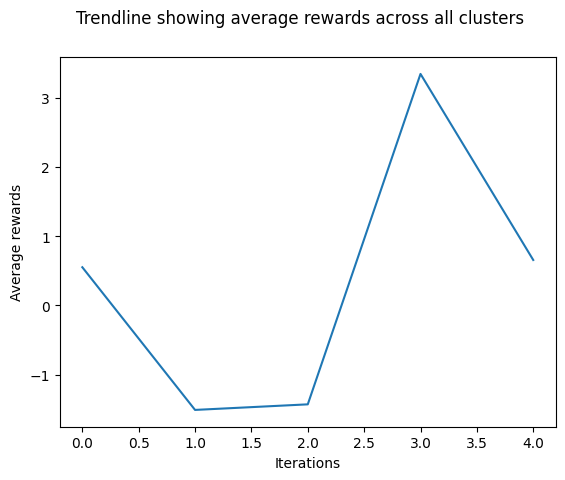

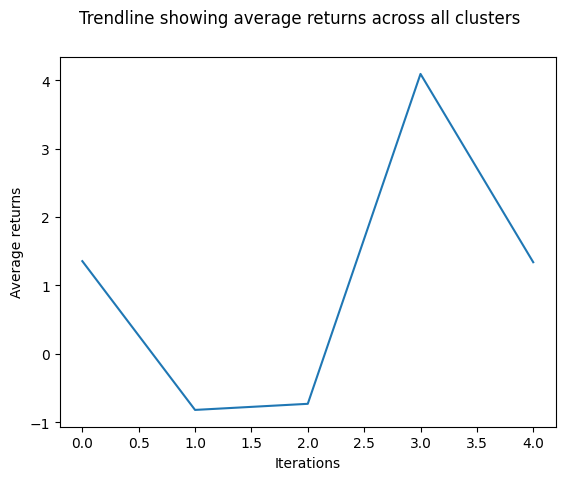

The average rewards and returns after 5 iterations are respectively 0.32223848608600114 and 1.047572275860372.


In [75]:
#average out the performances of all clusters over total_iter times
total_iter = 5
avg_n_performance(total_iter, good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)